In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from Windowing import *
from Plotting import Compare, PlotHeatmap, HeatmapBoxPlot, Meanplots

# 0. Introduction

In this notebook we will generate the plots used to show how well the methods perform in the binary context

# 1. Load the data

In [3]:
win.datasets

array([    3,     6,    11,    12,    13,    14,    16,    18,    21,
          22,    23,    24,    26,    28,    30,    31,    32,    36,
          38,    44,    46,    54,    55,    57,    60,    61,   179,
         180,   181,   182,   184,   185,   188,   201,   273,   293,
         299,   300,   336,   346,   351,   354,   357,   380,   389,
         390,   391,   392,   393,   395,   396,   398,   399,   401,
         446,   554,   679,   715,   718,   720,   722,   723,   727,
         728,   734,   735,   737,   740,   741,   743,   751,   752,
         761,   772,   797,   799,   803,   806,   807,   813,   816,
         819,   821,   822,   823,   833,   837,   843,   845,   846,
         847,   849,   866,   871,   881,   897,   901,   903,   904,
         910,   912,   913,   914,   917,   923,   930,   934,   953,
         958,   959,   962,   966,   971,   976,   977,   978,   979,
         980,   991,   993,   995,  1000,  1002,  1018,  1019,  1020,
        1021,  1036,

In [2]:
win = Windowing(aggCurves)
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896, 4096])

win.Last()
win.MDS()
win.MDS_low_budget_binary()
win.MMF(steps = 4000, lr = 0.01)


,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


# 2. Method

We want to compare how good each is in the binary context. To do this we will take the average difference in absolute error.
Here the error will be 1 if the prediction is wrong and 0 if it is correct (as to which learner wins in the binary problem).

In [3]:
win.help()

This class is used to analyse the results of different learning curve regression methods.
The results are stored in a dictionary called 'results'. To access them use the following syntax: self.results['method']['test error'][datasetID, learnerID, windowID, targetID]
To plot the results of a specific method, use the following functions: 

PlotCurveAndPrediction: plots the predictions and true values for a specific dataset, learner, window and target. This gives a zoomed in view of what is happening.

Boxplots: Given a specific slice of the dataset, learner, window and target, this function makes the corresponding boxplots. You can specify what you want to plot the boxplots over, by setting the xaxis parameter to 'dataset', 'learner', 'window' or 'target'.



In [3]:
# We make function so that it is easier to do for multiple different windows/targets
# This function will perform the binary comparison for the given data
def Binary(data):
    # Which learner would win in the binary problem
    predictions = (data[:,:,None] > data[:,None]).astype(float)

    # keep nans
    nans = np.isnan(data[:,:,None]) + np.isnan(data[:,None])
    predictions[nans] = np.nan

    # Make ties 0.5
    predictions[data[:,:,None] == data[:,None]] = 0.5

    # Don't compete against same learner
    np.einsum('ijj...->ij...', predictions)[...] = np.nan

    return predictions

In [4]:
# We get the binary predictions
MDSbinary = win.results['MDS']['binary']
MDSregression = Binary(win.results['MDS']['regression'])
MMF = Binary(win.results['MMF']['regression'])
Last = Binary(win.results['Last']['regression'])
actual = Binary(win.target)

In [5]:
# Tie means no learning curve crossing thus we predict the largest last anchor
# this is the same as using last
MDSbinary[MDSbinary == 0.5] = Last[MDSbinary == 0.5]
MDSregression[MDSregression == 0.5] = Last[MDSregression == 0.5]
MMF[MMF == 0.5] = Last[MMF == 0.5]
actual[actual == 0.5] = Last[actual == 0.5]
# Because we round down with int(0.5) later, right wins by default

In [6]:
# All true values, so we flip it around, now left is right and right is left. This is because we have set 1 as left and 0 as right
# in the binary setting, thus we flip it around here as numpy sees 1 as right and 0 as left
true = np.stack([win.target[:,None] +0*win.target[:,:,None], win.target[:,None]*0 +win.target[:,:,None]])

def regret_calc(dat):
    # Indexes for the predictions
    temp = np.copy(dat)
    nans = np.isnan(temp)
    temp[nans] = 0
    temp = temp.astype(int)

    # Indexes for the true values
    temp2 = np.copy(actual)
    nans2 = np.isnan(temp2)
    temp2[nans2] = 0
    temp2 = temp2.astype(int)

    # regret
    regret = np.squeeze(np.take_along_axis(true, temp2[None], axis=0) - np.take_along_axis(true, temp[None], axis=0))
    regret[nans] = np.nan
    regret[nans2] = np.nan

    return regret

In [7]:
# Regret for each method
MDSregret = regret_calc(MDSbinary)
MMFregret = regret_calc(MMF)
Lastregret = regret_calc(Last)

In [9]:
def PlotCurveAndPrediction(dataset, learner, window, target, scaled=True, legend=True):
    '''
    Given the learner, dataset and window this will return a scatter plot of the
    actual curve, the MMF predicted curve, the k-nearest curves (scaled) and the
    MDS prediction. It even plots the missing anchor points that are not included
    when tensorizing the calculations.
    '''
    fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])
    datasetID, learnerID, windowID, targetID = win._returnIDs(dataset, learner, window, target)

    if np.isnan(win.label[datasetID, learnerID, targetID]):
        warnings.warn("Given curve has no value at target point. Predictions can still be made and shown "
                      "but are not used in the error calculations.", UserWarning)

    stopID = np.where(win.points == win.target_anchors[targetID])[0][0]
    startID = np.where(win.points == win.train_anchors[windowID])[0][0]
    #ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetID, learnerID, startID+1:stopID], color='blue', marker='x',
    #           label='')

    # Last One prediction
    x = np.linspace(win.train_anchors[0], win.target_anchors[targetID], 10000)
    ax.plot(x, np.full(x.shape, win.segment[datasetID, learnerID, windowID]), color='green',
            label='Last')

    # MMF prediction plot
    a, b, c, d = win.results['MMF']['parameters'][datasetID, learnerID, 0, windowID]
    fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    ax.plot(x, fun(x), label='MMF')

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = win.results['MDS']['k closest curves ID'][datasetID, :, learnerID, windowID, targetID]

    for k in knn:
        if scaled:
            c = win.results['MDS']['scalar'][datasetID, k, learnerID, windowID]
            ax.scatter(win.points[:stopID + 1], c * win.dataframe[k, learnerID, :stopID + 1], s=5)
        else:
            ax.scatter(win.points[:stopID + 1], win.dataframe[k, learnerID, :stopID + 1], s=5)

    # MDS regression prediction
    ax.scatter(win.target_anchors[targetID],
               win.results['MDS']['regression'][datasetID, learnerID, windowID, targetID], color='red', marker='x',
               label='MDS')

    # set y axis and x axis name
    ax.set_ylabel('Accuracy', fontsize=15, fontweight='bold')
    ax.set_xlabel('Train set size', fontsize=15, fontweight='bold')

    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(win.train_anchors[:windowID + 1], win.segment[datasetID, learnerID][:windowID + 1], color='blue',
               marker='o', label='Anchors in curve segment')
    ax.scatter(win.target_anchors[targetID], win.label[datasetID, learnerID, targetID], color='red', label='Target anchor')

    # make a title
    ax.set_title('Dataset: {}, Learner: {}, Last anchor in curve segment: {}, Target anchor: {}'.format('kr-vs-kp',
                                                                                     win.Slearners[learnerID],
                                                                                          win.train_anchors[
                                                                                              windowID],
                                                                                          win.target_anchors[
                                                                                              targetID]), fontweight='bold')

    if legend:
        ax.legend()

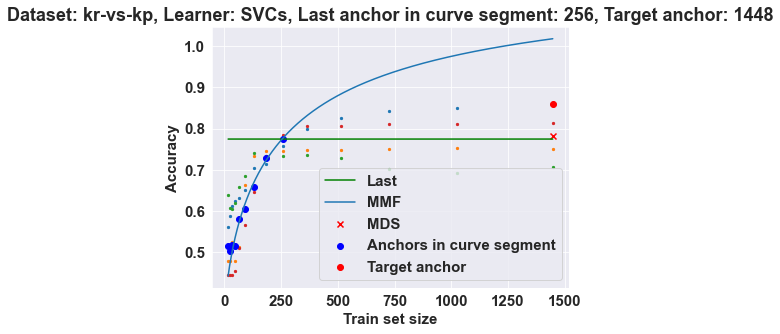

In [48]:
PlotCurveAndPrediction(0,3,8,12, legend = True)
plt.savefig('../Plots/Paper/predictions.pdf', dpi=300, bbox_inches='tight')

# 3. Results

ValueError: Must pass 2-d input. shape=(20, 20, 16)

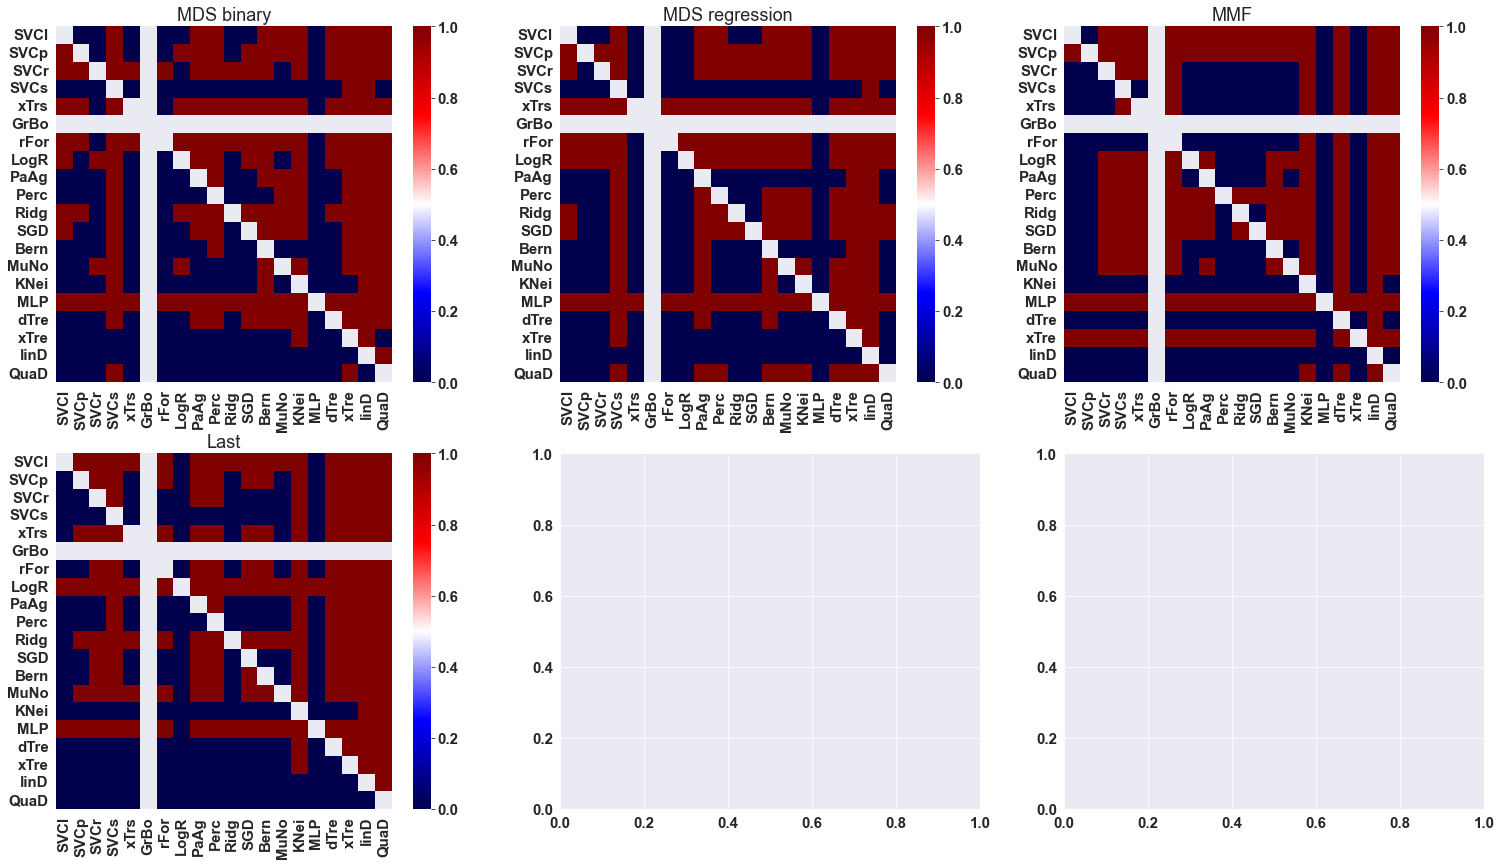

In [88]:
# For the singular we need to choose a dataset, window and target
DS = 12
Win = 4
Target = -1


title = ('Dataset: {}, Last anchor in window: {}, Target: {}'.format(win.datasets[DS],
                                                                                  win.train_anchors[Win],win.target_anchors[Target]))

MDSbin_plot = MDSbinary[DS,:,:,Win,Target]
MDSreg_plot = MDSregression[DS,:,:,Win,Target]
MMF_plot = MMF[DS,:,:,Win,Target,]
Last_plot = Last[DS,:,:,Win,Target]
actual_plot = actual[DS,:,:,Target]

plots = {'MDS binary':MDSbin_plot, 'MDS regression':MDSreg_plot, 'MMF':MMF_plot, 'Last':Last_plot, 'Actual':actual_plot}

PlotHeatmap(plots, label=True, title = title)

C:\Users\lkiel\PycharmProjects\AMLthesis\HelperFiles\Plotting.py:135: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


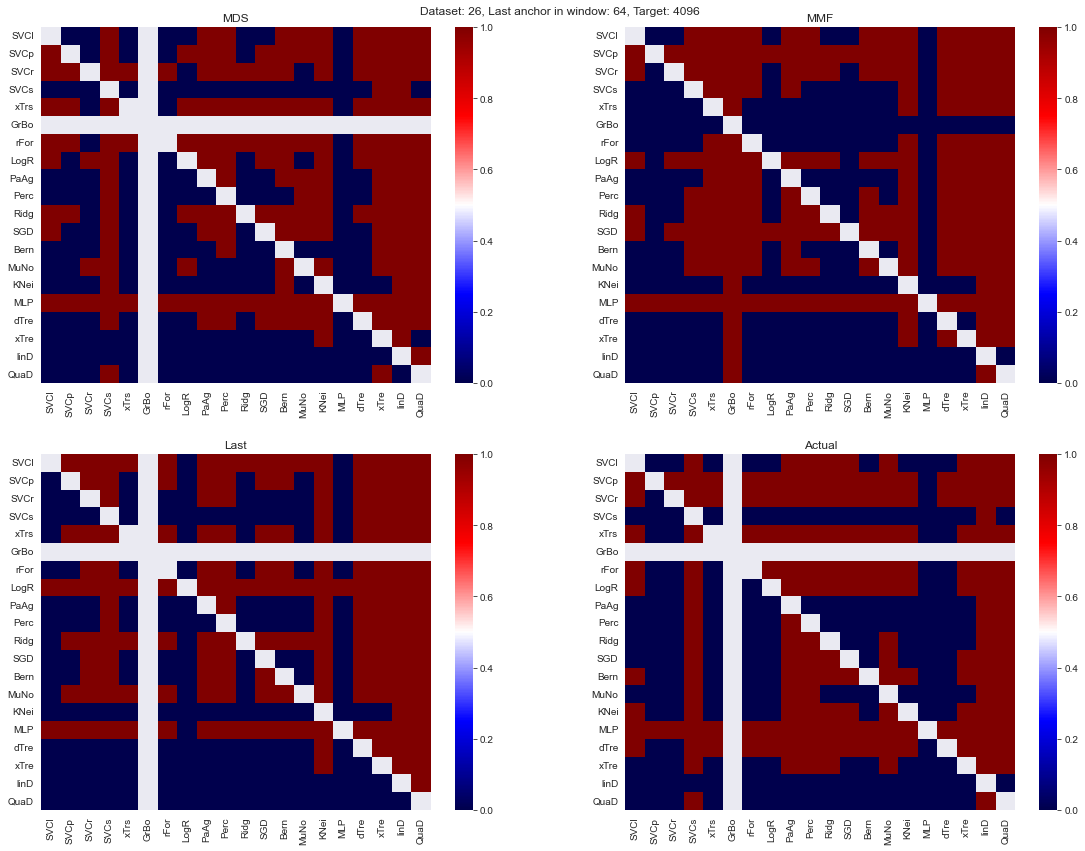

In [9]:
# For the singular we need to choose a dataset, window and target
DS = 12
Win = 4
Target = -1


title = ('Dataset: {}, Last anchor in window: {}, Target: {}'.format(win.datasets[DS],
                                                                                  win.train_anchors[Win],win.target_anchors[Target]))

MDSbin_plot = MDSbinary[DS,:,:,Win,Target]
MDSreg_plot = MDSregression[DS,:,:,Win,Target]
MMF_plot = MMF[DS,:,:,Win,Target,]
Last_plot = Last[DS,:,:,Win,Target]
actual_plot = actual[DS,:,:,Target]

plots = {'MDS':MDSbin_plot, 'MMF':MMF_plot, 'Last':Last_plot, 'Actual':actual_plot}

PlotHeatmap(plots, label=True, title = title)

In [10]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.weight': 'bold'})

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from MainFiles.deprecated_Methods_fixed_window_size import Slearners

In [11]:
def PlotHeatmap(plots, label=False, min=0, max=1, cmap='seismic', title=None):
    # If we dont put in a list and just want one plot
    if type(plots) == np.ndarray:
        n = 1
        fig, ax = plt.subplots(1, 1, figsize=[6.4 * 2, 4.8 * 2])
        sns.heatmap(plots, vmin=min, vmax=max, cmap=cmap)
        if label:
            ax.set_yticklabels(Slearners, rotation=0)
            ax.set_xticklabels(Slearners, rotation=90)
    else:
        labels, data = [*zip(*plots.items())]
        n = len(data)

        # The smallest square in which to fit all the subplots
        square = int(np.ceil(np.sqrt(n)))
        # Since we can make a rectangle instead of a square we check the minimum rows we need
        rows = int(np.ceil(n / square))

        # Default figsize is [6.4,4.8] so I just double the width
        fig, ax = plt.subplots(rows, square, figsize=[6.4 * (square + 1), 4.8 * (rows + 1)])
        i = 0
        for axis in ax.flatten():
            if i < n:
                sns.heatmap(data[i], ax=axis, vmin=min, vmax=max, cmap=cmap)
                axis.set_title(labels[i])
                if label:
                    axis.set_yticklabels(Slearners, rotation=0)
                    axis.set_xticklabels(Slearners, rotation=90)
            else:
                axis.set_axis_off()
            i += 1
        # set the spacing between subplots
        # fig.subplots_adjust(wspace=0.4,hspace=0.4)
        fig.show()

    if title:
        fig.suptitle(title, y=0.9)

def HeatmapBoxPlot(plots, ylabel=None, hline='N', ylim=None, label=False, min=0, max=1, cmap='seismic', title=None):
    nplots = len(plots)
    fig, ax = plt.subplots(nplots, 2, figsize = (16,20))
    axis = ax.flatten()
    labels, data = [*zip(*plots.items())]
    if title:
        fig.suptitle(title, fontsize=20, fontweight='bold')
    for i in range(nplots):
        axis[2 * i].set_title(labels[i], fontsize=15, fontweight='bold')
        axis[2 * i + 1].set_title(labels[i], fontsize=15, fontweight='bold')
        sns.heatmap(data[i], cmap=cmap, vmin=min, vmax=max, ax=axis[2 * i])
        if label:
            axis[2 * i].set_yticklabels(Slearners, rotation=0, fontsize=15, fontweight='bold')
            axis[2 * i].set_xticklabels(Slearners, rotation=90, fontsize=15, fontweight='bold')
        axis[2 * i + 1].boxplot(data[i][~np.isnan(data[i])].ravel())
        if ylim:
            axis[2 * i + 1].set_ylim(*ylim)
        if ylabel:
            axis[2 * i + 1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
        if hline != 'N':
            axis[2 * i + 1].axhline(hline, linestyle='--')
    plt.tight_layout()
    fig.show()


def Compare(algos, truth_reference, ylabel='Average Difference in Error', hline=0, ylim=None, label=False,
            min=-1, max=1, cmap='seismic', title=None):
    labels, data = [*zip(*algos.items())]
    shape = truth_reference.shape
    d = []
    for i, dat in enumerate(data):
        dat1 = dat[0]
        dat2 = dat[1]
        while dat1.shape != shape:
            dat1 = np.einsum('ijk -> jki', dat1)
        while dat2.shape != shape:
            dat2 = np.einsum('ijk -> jki', dat2)
        d.append((dat1, dat2))

    plots = {labels[i]: (np.nanmean(np.abs(d[i][0] - truth_reference) -
                         np.abs(d[i][1] - truth_reference), axis=0)) for i in range(len(labels))}
    HeatmapBoxPlot(plots, ylabel, hline, ylim, label, min, max, cmap, title)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\597315358.py:9: RuntimeWarning: Mean of empty slice
  MDS_vs_MMF = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(MMF_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\597315358.py:10: RuntimeWarning: Mean of empty slice
  MDS_vs_Last = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\597315358.py:11: RuntimeWarning: Mean of empty slice
  MMF_vs_Last = np.nanmean(np.abs(MMF_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\597315358.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


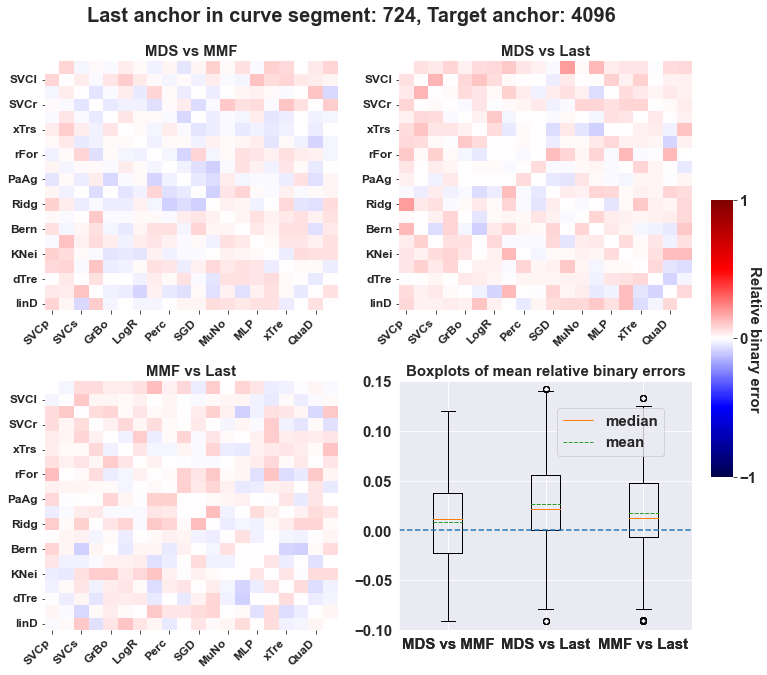

In [20]:
Win = -5
Target = -1

MDS_Agg1 = MDSbinary[:,:,:,Win,Target]
MMF_Agg1 = MMF[:,:,:,Win,Target]
Last_Agg1 = Last[:,:,:,Win,Target]
actual_Agg1 = actual[:,:,:,Win,Target]

MDS_vs_MMF = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(MMF_Agg1 - actual_Agg1), axis=0)
MDS_vs_Last = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
MMF_vs_Last = np.nanmean(np.abs(MMF_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)

#diagonals to 0
np.fill_diagonal(MDS_vs_MMF, 0)
np.fill_diagonal(MDS_vs_Last, 0)
np.fill_diagonal(MMF_vs_Last, 0)


title = ('Last anchor in curve segment: {}, Target anchor: {}'.format(win.train_anchors[Win],win.target_anchors[Target]))
fig, ax = plt.subplots(2, 2, figsize = (5*2,4.8*2))

# make a new colorbar axis
cbar_ax = fig.add_axes([1, .3, .03, .4])


sns.heatmap(MDS_vs_MMF, vmin=-1, vmax=1, cmap='seismic', ax = ax[0,0], cbar_ax = None, cbar = False)
ax[0,0].set_title('MDS vs MMF', fontsize=15, fontweight='bold')
ax[0,0].tick_params(left=True, bottom=True)

sns.heatmap(MDS_vs_Last, vmin=-1, vmax=1, cmap='seismic', ax = ax[0,1], cbar_ax = None, cbar = False)
ax[0,1].set_title('MDS vs Last', fontsize=15, fontweight='bold')
ax[0,1].tick_params(left=True, bottom=True)

sns.heatmap(MMF_vs_Last, vmin=-1, vmax=1, cmap='seismic', ax = ax[1,0], cbar_ax=cbar_ax, cbar_kws={'label': 'Relative binary error', 'orientation': 'vertical', 'ticks': [-1, 0, 1]})
ax[1,0].set_title('MMF vs Last', fontsize=15, fontweight='bold')
ax[1,0].tick_params(left=True, bottom=True)
cbar_ax.yaxis.label.set_size(15)
cbar_ax.yaxis.label.set_weight('bold')
cbar_ax.yaxis.label.set_rotation(270)

# set tick labels
ticks = np.arange(len(Slearners)) + 0.5
#index = [np.arange(0, len(Slearners), 3).astype(int), np.arange(1, len(Slearners), 3), np.arange(2, len(Slearners), 3)]
index = [np.arange(0, len(Slearners),2), np.arange(1, len(Slearners), 2)]
Slearners = np.array(Slearners)
for i,id in enumerate([(0,0), (0,1), (1,0)]):
    ax[id].set_xticks(ticks[index[0]])
    ax[id].set_yticks(ticks[index[1]])
    ax[id].set_yticklabels(Slearners[index[0]], rotation=0, fontsize=12, fontweight='bold')
    ax[id].set_xticklabels(Slearners[index[1]], rotation=45, fontsize=12, fontweight='bold', ha='right')


bplots = [MDS_vs_MMF[~np.isnan(MDS_vs_MMF)].ravel(), MDS_vs_Last[~np.isnan(MDS_vs_Last)].ravel(), MMF_vs_Last[~np.isnan(MMF_vs_Last)].ravel()]
ax[1,1].boxplot(bplots, labels=['MDS vs MMF', 'MDS vs Last', 'MMF vs Last'], showmeans=True, meanline=True)
bp = ax[1,1].boxplot(bplots, labels=['MDS vs MMF', 'MDS vs Last', 'MMF vs Last'], showmeans=True, meanline=True)
ax[1,1].axhline(0,linestyle='--')
ax[1,1].set_ylim([-0.1,0.15])
ax[1,1].set_title('Boxplots of mean relative binary errors', fontsize=15, fontweight='bold')

# legend
ax[1,1].legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc = (0.54,0.7))

plt.suptitle(title, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig('../Plots/Paper/Agg1.png', dpi=300, bbox_inches='tight')

# 4. Boxplots
We will take 'MDS' as MDS binary as it performs better, we will do comparison between MDS, MMF and Last over windows at specific targets

In [12]:
def Meanplots(plots, ylabel=None, xlabel=None, hline='N', xrot=False, ylim=None, figsize=(1, 1),
             col=['black', 'red', 'blue', 'green'], legend_loc='upper right', title=None, save=None, dpi=800, Q1Q3=True, median=True, ls='--'):
    plotlabels = list(plots.keys())
    w, h = *figsize,
    fig, ax = plt.subplots(figsize=(6.4 * w, 4.8 * h))
    if ylim:
        ax.set_ylim(*ylim)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=15, fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=15, fontweight='bold')
    if hline != 'N':
        plt.axhline(hline, linestyle=ls)
    if title:
        fig.suptitle(title, y=1, fontsize=20, fontweight='bold')

    n_dicts = len(plots)
    if type(plots[plotlabels[0]]) != dict:
        n_dicts = 1
    for i in range(n_dicts):
        c = col[i]
        if n_dicts == 1:
            labels, data = [*zip(*plots.items())]
        else:
            labels, data = [*zip(*plots[plotlabels[i]].items())]
        data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
        means = [np.mean(dat) for dat in data]
        ax.plot(means, c=c, label=plotlabels[i])
        #dotted line
        if median:
            medians = [np.quantile(dat, 0.5) for dat in data]
            ax.plot(medians, c=c, linestyle='dotted')
        if Q1Q3:
            q1s = [np.quantile(dat, 0.25) for dat in data]
            q3s = [np.quantile(dat, 0.75) for dat in data]
            ax.fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
    pos = np.arange(0, len(labels))
    ax.set_xticks(pos)
    if xrot:
        ax.set_xticklabels(labels, rotation=45, ha='right')
    else:
        ax.set_xticklabels(labels)
    if n_dicts != 1:
        ax.legend(loc=legend_loc)
    if save:
        plt.savefig(save, dpi=dpi)
    plt.show()

In [13]:
MMF.shape

(248, 20, 20, 16, 16)

In [14]:
# Broadcast actual

# Get errors
MDS_error = np.nanmean(np.abs(MDSbinary - actual),axis=0)
MMF_error = np.nanmean(np.abs(MMF - actual), axis=0)
Last_error = np.nanmean(np.abs(Last - actual), axis=0)

MDS_error2 = np.nanmean(np.abs(MDSbinary - actual),axis=(1,2))
MMF_error2 = np.nanmean(np.abs(MMF - actual), axis=(1,2))
Last_error2 = np.nanmean(np.abs(Last - actual), axis=(1,2))

# Same for regret
Mean_MDSregret = np.nanmean(MDSregret, axis=0)
Mean_MMFregret = np.nanmean(MMFregret, axis=0)
Mean_Lastregret = np.nanmean(Lastregret, axis=0)

Mean_MDSregret2 = np.nanmean(MDSregret, axis=(1,2))
Mean_MMFregret2 = np.nanmean(MMFregret, axis=(1,2))
Mean_Lastregret2 = np.nanmean(Lastregret, axis=(1,2))

C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:4: RuntimeWarning: Mean of empty slice
  MDS_error = np.nanmean(np.abs(MDSbinary - actual),axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:5: RuntimeWarning: Mean of empty slice
  MMF_error = np.nanmean(np.abs(MMF - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:6: RuntimeWarning: Mean of empty slice
  Last_error = np.nanmean(np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:8: RuntimeWarning: Mean of empty slice
  MDS_error2 = np.nanmean(np.abs(MDSbinary - actual),axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:9: RuntimeWarning: Mean of empty slice
  MMF_error2 = np.nanmean(np.abs(MMF - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\678183284.py:10: RuntimeWarning: Mean of empty slice
  Last_error2 = np.nanmean(np.abs(Last - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local

In [15]:
MDSvsMMF = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=0)
MMFvsLast = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=0)
MDSvsLast = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=0)

MDSvsMMF2 = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=(1,2))
MMFvsLast2 = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=(1,2))
MDSvsLast2 = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=(1,2))

# Regret
MDSregretvsMMFregret = np.nanmean(MDSregret - MMFregret, axis=0)
MMFregretvsLastregret = np.nanmean(MMFregret - Lastregret, axis=0)
MDSregretvsLastregret = np.nanmean(MDSregret - Lastregret, axis=0)

MDSregretvsMMFregret2 = np.nanmean(MDSregret - MMFregret, axis=(1,2))
MMFregretvsLastregret2 = np.nanmean(MMFregret - Lastregret, axis=(1,2))
MDSregretvsLastregret2 = np.nanmean(MDSregret - Lastregret, axis=(1,2))

C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:1: RuntimeWarning: Mean of empty slice
  MDSvsMMF = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:2: RuntimeWarning: Mean of empty slice
  MMFvsLast = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:3: RuntimeWarning: Mean of empty slice
  MDSvsLast = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:5: RuntimeWarning: Mean of empty slice
  MDSvsMMF2 = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:6: RuntimeWarning: Mean of empty slice
  MMFvsLast2 = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\1498662332.py:7:

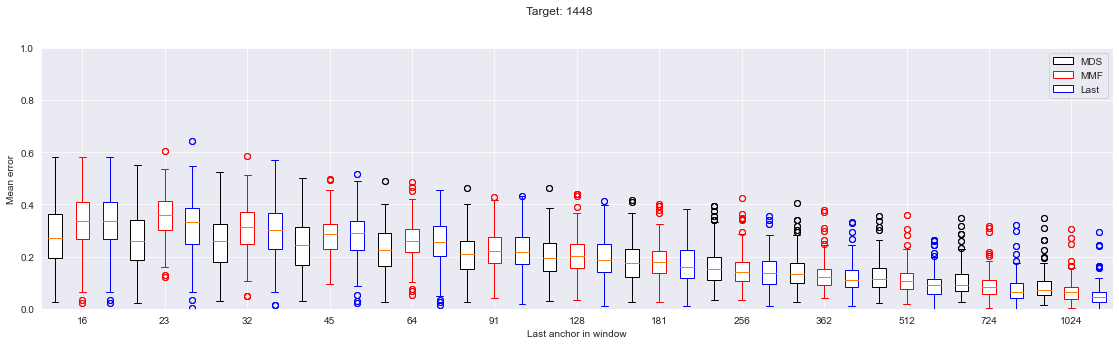

In [38]:
# We only need to choose a target
Target = -4

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}

path = '..\Plots\BinaryAggregation2Bplots\BinaryAggregation2Bplotstarget{}.png'.format(Target)
Boxplots(plots, title = 'Target: {}'.format(win.target_anchors[Target]), ylim = (0,1), figsize=(3, 1), save=path, xlabel='Last anchor in window', ylabel='Mean error')



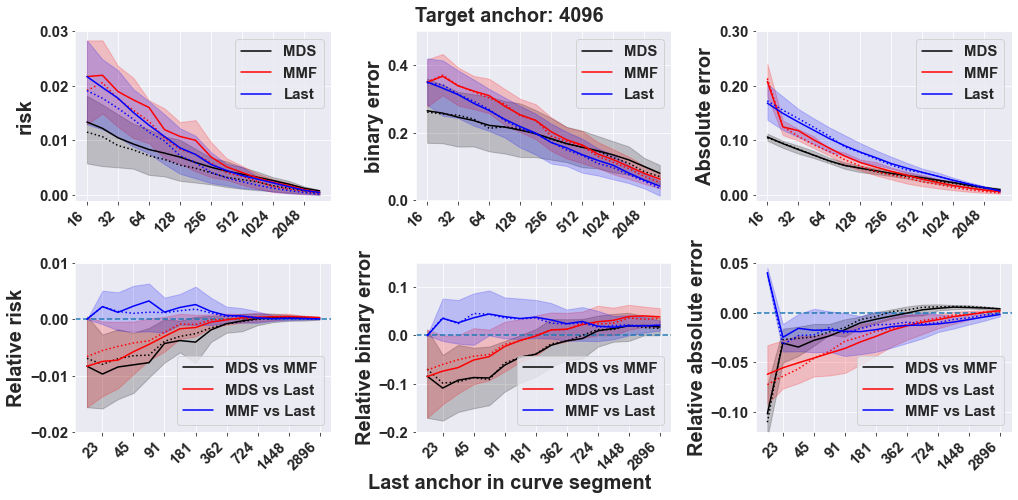

In [22]:
plots = {}
Target = -1
if Target != -1:
    ind = range(len(win.train_anchors))[:Target + 1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): Mean_MDSregret[..., i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): Mean_MMFregret[..., i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Mean_Lastregret[..., i, Target] for i in ind}

plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target + 1]
else:
    ind = range(len(win.train_anchors))
plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSregretvsMMFregret[..., i, Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSregretvsLastregret[..., i, Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFregretvsLastregret[..., i, Target] for i in ind}

ylim2 = (-0.02, 0.01)
hline2 = 0
legend_loc2 = 'lower right'

title = 'Target anchor: {}'.format(win.target_anchors[Target])
ylim = (-0.001, 0.03)
figsize = (1.5*1.5, 1*1.5)
xlabel = 'Last anchor in window'
ylabel1 = 'Mean risk'
Q1Q3 = True
median = True
save = '..\Plots\Paper\Agg2.png'
dpi = 300
xrot = False
col = ['black', 'red', 'blue', 'green']
legend_loc = 'upper right'
Q1Q3 = True
median = True
ls = '--'
hline = 'N'

plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(2, 3, figsize=(6.4 * w, 4.8 * h))
if ylim:
    ax[0][0].set_ylim(*ylim)
    ax[1][0].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][0].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=1, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][0].plot(means, c=c, label=plotlabels[i])
    ax[1][0].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][0].plot(medians, c=c, linestyle='dotted')
        ax[1][0].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][0].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][0].set_xticks(pos[::2])
ax[1][0].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][0].set_xticklabels(labels[::2], rotation=45, ha='right')
    ax[1][0].set_xticklabels(labels[1::2], rotation=45, ha='right')
    ax[0][0].tick_params(left=True, bottom=True)
    ax[1][0].tick_params(left=True, bottom=True)
if n_dicts != 1:
    ax[0][0].legend(loc=legend_loc)
    ax[1][0].legend(loc=legend_loc2)


#Plot 2
plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}

ylim = (-0.001, 0.5)
ylim2 = (-0.2,0.15)


if ylim:
    ax[0][1].set_ylim(*ylim)
    ax[1][1].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][1].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][1].plot(means, c=c, label=plotlabels[i])
    ax[1][1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][1].plot(medians, c=c, linestyle='dotted')
        ax[1][1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][1].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][1].set_xticks(pos[::2])
ax[1][1].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][1].set_xticklabels(labels[::2], rotation=45, ha='right')
    ax[1][1].set_xticklabels(labels[1::2], rotation=45, ha='right')
    # enable tick lines
    ax[0][1].tick_params(left=True, bottom=True)
    ax[1][1].tick_params(left=True, bottom=True)
if n_dicts != 1:
    ax[0][1].legend(loc=legend_loc)
    ax[1][1].legend(loc=legend_loc2)




#Plot 3
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots['MDS'] = {str(win.train_anchors[i]): KaveragesMDS[:,i,Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): KaveragesMMF[:,i,Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): KaveragesLast[:,i,Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots2['MDS vs MMF'] = {str(win.train_anchors[i]): KaveragesMDSvsMMF[:,i,Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): KaveragesMDSvsLast[:,i,Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): KaveragesMMFvsLast[:,i,Target] for i in ind}


ylim2 = (-0.12,0.05)
hline2 = 0
legend_loc2 = 'lower right'

ylim = (-0.01,0.3)
xlabel='Last anchor in curve segment'
ylabel2='Mean difference in absolute error'
Q1Q3=True
median=True
legend_loc='upper right'
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
if ylim:
    ax[0][2].set_ylim(*ylim)
    ax[1][2].set_ylim(*ylim2)
#if ylabel:
#    ax[0][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#    ax[1][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#if xlabel:
#    ax[1][1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][2].axhline(hline2, linestyle=ls)

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][2].plot(means, c=c, label=plotlabels[i])
    ax[1][2].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][2].plot(medians, c=c, linestyle='dotted')
        ax[1][2].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][2].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][2].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][2].set_xticks(pos[::2])
ax[1][2].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][2].set_xticklabels(labels[::2], rotation=45, ha='right')
    ax[1][2].set_xticklabels(labels[1::2], rotation=45, ha='right')
    #enable tick lines
    ax[0][2].tick_params(bottom=True, left = True)
    ax[1][2].tick_params(bottom=True, left = True)
if n_dicts != 1:
    ax[0][2].legend(loc=legend_loc)
    ax[1][2].legend(loc=legend_loc2)


#if save:
fig.suptitle(title, y=0.90, fontsize=25, fontweight='bold')
ax[1][0].yaxis.set_major_locator(plt.MaxNLocator(3))

# Common labels
fig.text(0.5, 0, xlabel, ha='center', fontsize=20, fontweight='bold')
#fig.text(0, 0.5, ylabel1, va='center', rotation='vertical', fontsize=20, fontweight='bold')
#fig.text(0.99, 0.5, ylabel2, va='center', rotation=270, fontsize=20, fontweight='bold')

# per plot labels
ax[0][1].set_ylabel('binary error', fontsize=20, fontweight='bold')
ax[1][1].set_ylabel('Relative binary error', fontsize=20, fontweight='bold')
ax[0][0].set_ylabel('risk', fontsize=20, fontweight='bold')
ax[1][0].set_ylabel('Relative risk', fontsize=20, fontweight='bold')
ax[0][2].set_ylabel('Absolute error', fontsize=20, fontweight='bold')
ax[1][2].set_ylabel('Relative absolute error', fontsize=20, fontweight='bold')

from matplotlib.ticker import FormatStrFormatter
# set yaxis labels to be 2 decimals
ax[0][2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()

if title:
    fig.suptitle(title, y=0.93, fontsize=20, fontweight='bold')

plt.savefig(save, dpi=dpi, bbox_inches='tight')


plt.show()

In [49]:
str = ''
for i in range(len(win.learners)):
    temp = win.learners[i].split('.')[-1]
    temp = temp.replace('_', '')
    #str += win.Slearners[i] + ': ' + temp + ', '
    str += temp + ', '

print(str)

SVClinear, SVCpoly, SVCrbf, SVCsigmoid, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, BernoulliNB, MultinomialNB, KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier, ExtraTreeClassifier, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, 


NameError: name 'KaveragesMDS' is not defined

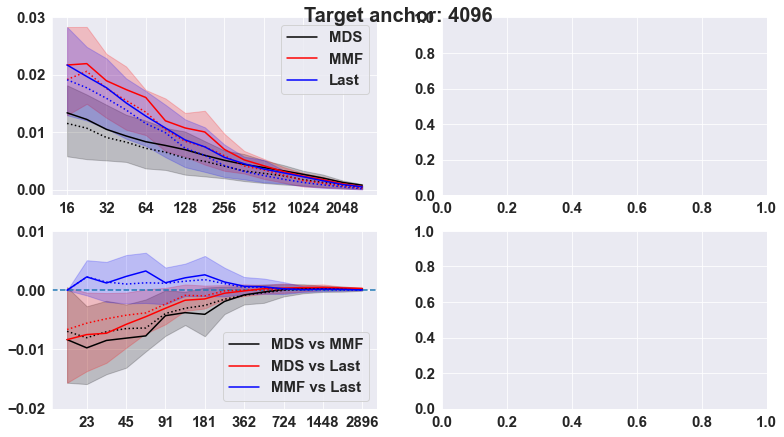

In [16]:
plots = {}
Target = -1
if Target != -1:
    ind = range(len(win.train_anchors))[:Target + 1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): Mean_MDSregret[..., i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): Mean_MMFregret[..., i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Mean_Lastregret[..., i, Target] for i in ind}

plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target + 1]
else:
    ind = range(len(win.train_anchors))
plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSregretvsMMFregret[..., i, Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSregretvsLastregret[..., i, Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFregretvsLastregret[..., i, Target] for i in ind}

ylim2 = (-0.02, 0.01)
hline2 = 0
legend_loc2 = 'lower right'



title = 'Target anchor: {}'.format(win.target_anchors[Target])
ylim = (-0.001, 0.03)
figsize = (2, 1.5)
xlabel = 'Last anchor in window'
ylabel1 = 'Mean risk'
Q1Q3 = True
median = True
save = '..\Plots\Paper\Agg2RegretAbs.png'
dpi = 300
xrot = False
col = ['black', 'red', 'blue', 'green']
legend_loc = 'upper right'
Q1Q3 = True
median = True
ls = '--'
hline = 'N'

plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(2, 2, figsize=(6.4 * w, 4.8 * h))
if ylim:
    ax[0][0].set_ylim(*ylim)
    ax[1][0].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][0].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][0].plot(means, c=c, label=plotlabels[i])
    ax[1][0].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][0].plot(medians, c=c, linestyle='dotted')
        ax[1][0].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][0].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][0].set_xticks(pos[::2])
ax[1][0].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][0].set_xticklabels(labels[::2])
    ax[1][0].set_xticklabels(labels[1::2])
if n_dicts != 1:
    ax[0][0].legend(loc=legend_loc)
    ax[1][0].legend(loc=legend_loc2)



#Plot 2
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots['MDS'] = {str(win.train_anchors[i]): KaveragesMDS[:,i,Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): KaveragesMMF[:,i,Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): KaveragesLast[:,i,Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots2['MDS vs MMF'] = {str(win.train_anchors[i]): KaveragesMDSvsMMF[:,i,Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): KaveragesMDSvsLast[:,i,Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): KaveragesMMFvsLast[:,i,Target] for i in ind}


ylim2 = (-0.12,0.05)
hline2 = 0
legend_loc2 = 'lower right'

ylim = (-0.01,0.3)
xlabel='Last anchor in window'
ylabel2='Mean difference in absolute error'
Q1Q3=True
median=True
legend_loc='upper right'
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
if ylim:
    ax[0][1].set_ylim(*ylim)
    ax[1][1].set_ylim(*ylim2)
#if ylabel:
#    ax[0][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#    ax[1][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#if xlabel:
#    ax[1][1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][1].axhline(hline2, linestyle=ls)

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][1].plot(means, c=c, label=plotlabels[i])
    ax[1][1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][1].plot(medians, c=c, linestyle='dotted')
        ax[1][1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][1].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][1].set_xticks(pos[::2])
ax[1][1].set_xticks(pos[1::2])
ax[0][1].yaxis.tick_right()
ax[1][1].yaxis.tick_right()

if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][1].set_xticklabels(labels[::2])
    ax[1][1].set_xticklabels(labels[1::2])
#if n_dicts != 1:
#    ax[0][1].legend(loc=legend_loc)
#    ax[1][1].legend(loc=legend_loc2)


#if save:
fig.suptitle(title, y=0.90, fontsize=25, fontweight='bold')
ax[1][0].yaxis.set_major_locator(plt.MaxNLocator(3))

# Common labels
fig.text(0.5, 0, xlabel, ha='center', fontsize=20, fontweight='bold')
fig.text(0, 0.5, ylabel1, va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(0.99, 0.5, ylabel2, va='center', rotation=270, fontsize=20, fontweight='bold')

ax[0][0].set_title('Binary', fontsize=20, fontweight='bold', loc = 'left')
ax[0][1].set_title('Regression', fontsize=20, fontweight='bold', loc = 'right')

plt.tight_layout()



plt.savefig(save, dpi=dpi, bbox_inches='tight')


plt.show()

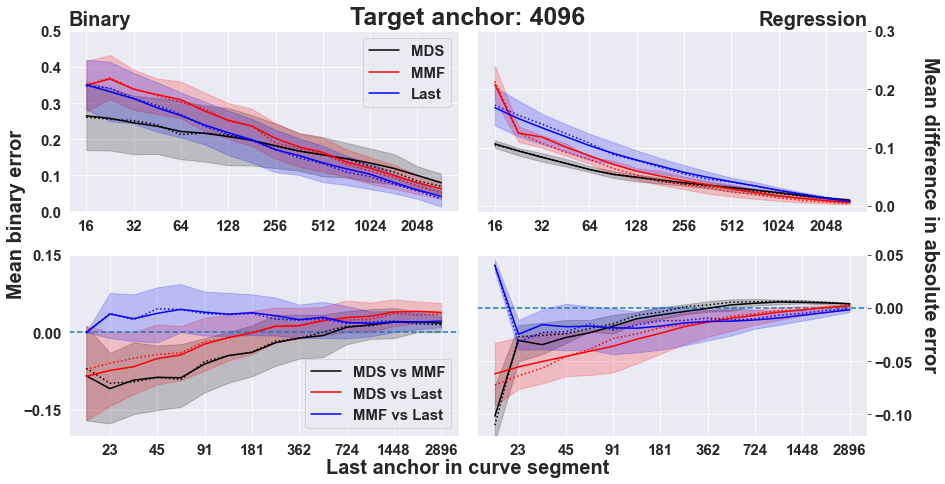

In [20]:
plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}


ylim2 = (-0.2,0.15)
hline2 = 0
legend_loc2 = 'lower right'

title = 'Target anchor: {}'.format(win.target_anchors[Target])
ylim = (-0.001, 0.5)
figsize = (2, 1.5)
xlabel='Last anchor in window'
ylabel1='Mean binary error'
Q1Q3 = True
median = True
save = '..\Plots\Paper\Agg2BinaryAbs.png'
dpi = 300
xrot = False
col = ['black', 'red', 'blue', 'green']
legend_loc = 'upper right'
Q1Q3 = True
median = True
ls = '--'
hline = 'N'

plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(2, 2, figsize=(6.4 * w, 4.8 * h))
if ylim:
    ax[0][0].set_ylim(*ylim)
    ax[1][0].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][0].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][0].plot(means, c=c, label=plotlabels[i])
    ax[1][0].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][0].plot(medians, c=c, linestyle='dotted')
        ax[1][0].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][0].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][0].set_xticks(pos[::2])
ax[1][0].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][0].set_xticklabels(labels[::2])
    ax[1][0].set_xticklabels(labels[1::2])
if n_dicts != 1:
    ax[0][0].legend(loc=legend_loc)
    ax[1][0].legend(loc=legend_loc2)



#Plot 2
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots['MDS'] = {str(win.train_anchors[i]): KaveragesMDS[:,i,Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): KaveragesMMF[:,i,Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): KaveragesLast[:,i,Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots2['MDS vs MMF'] = {str(win.train_anchors[i]): KaveragesMDSvsMMF[:,i,Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): KaveragesMDSvsLast[:,i,Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): KaveragesMMFvsLast[:,i,Target] for i in ind}


ylim2 = (-0.12,0.05)
hline2 = 0
legend_loc2 = 'lower right'


ylim = (-0.01,0.3)
xlabel='Last anchor in curve segment'
ylabel2='Mean difference in absolute error'
Q1Q3=True
median=True
legend_loc='upper right'
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
if ylim:
    ax[0][1].set_ylim(*ylim)
    ax[1][1].set_ylim(*ylim2)
#if ylabel:
#    ax[0][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#    ax[1][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#if xlabel:
#    ax[1][1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1][1].axhline(hline2, linestyle=ls)

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0][1].plot(means, c=c, label=plotlabels[i])
    ax[1][1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0][1].plot(medians, c=c, linestyle='dotted')
        ax[1][1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0][1].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1][1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0][1].set_xticks(pos[::2])
ax[1][1].set_xticks(pos[1::2])
ax[0][1].yaxis.tick_right()
ax[1][1].yaxis.tick_right()

if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0][1].set_xticklabels(labels[::2])
    ax[1][1].set_xticklabels(labels[1::2])
#if n_dicts != 1:
#    ax[0][1].legend(loc=legend_loc)
#    ax[1][1].legend(loc=legend_loc2)




#if save:
fig.suptitle(title, y=0.90, fontsize=25, fontweight='bold')
ax[1][0].yaxis.set_major_locator(plt.MaxNLocator(3))

# Common labels
fig.text(0.5, 0, xlabel, ha='center', fontsize=20, fontweight='bold')
fig.text(0, 0.5, ylabel1, va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(0.99, 0.5, ylabel2, va='center', rotation=270, fontsize=20, fontweight='bold')

ax[0][0].set_title('Binary', fontsize=20, fontweight='bold', loc = 'left')
ax[0][1].set_title('Regression', fontsize=20, fontweight='bold', loc = 'right')
plt.tight_layout()
plt.savefig(save, dpi=dpi, bbox_inches='tight')


plt.show()

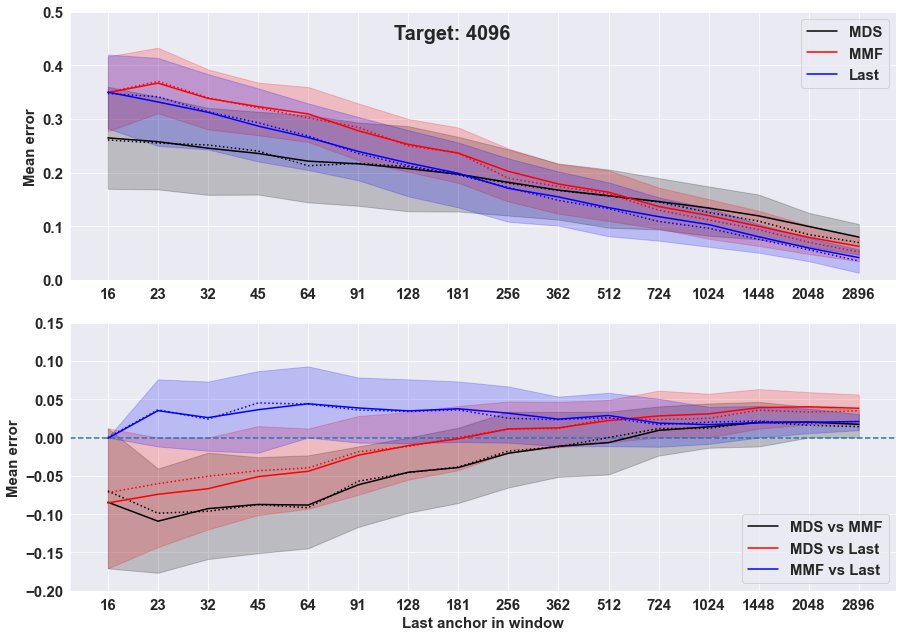

In [64]:


plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}


ylim2 = (-0.2,0.15)
hline2 = 0
legend_loc2 = 'lower right'


title = 'Target: {}'.format(win.target_anchors[Target])
ylim = (0,0.5)
figsize=(2, 2)
xlabel='Last anchor in window'
ylabel='Mean error'
Q1Q3=True
median=True
save='..\Plots\Paper\Binary1.png'
dpi=300
xrot=False
col=['black', 'red', 'blue', 'green']
legend_loc='upper right'
Q1Q3=True
median=True
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(2,1,figsize=(6.4 * w, 4.8 * h))
if ylim:
    ax[0].set_ylim(*ylim)
    ax[1].set_ylim(*ylim2)
if ylabel:
    ax[0].set_ylabel(ylabel, fontsize=15, fontweight='bold')
    ax[1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
if xlabel:
    ax[1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0].plot(means, c=c, label=plotlabels[i])
    ax[1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0].plot(medians, c=c, linestyle='dotted')
        ax[1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0].set_xticks(pos)
ax[1].set_xticks(pos)
plt.tight_layout()
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)
if n_dicts != 1:
    ax[0].legend(loc=legend_loc)
    ax[1].legend(loc=legend_loc2)
if save:
    plt.savefig(save, dpi=dpi)
plt.show()

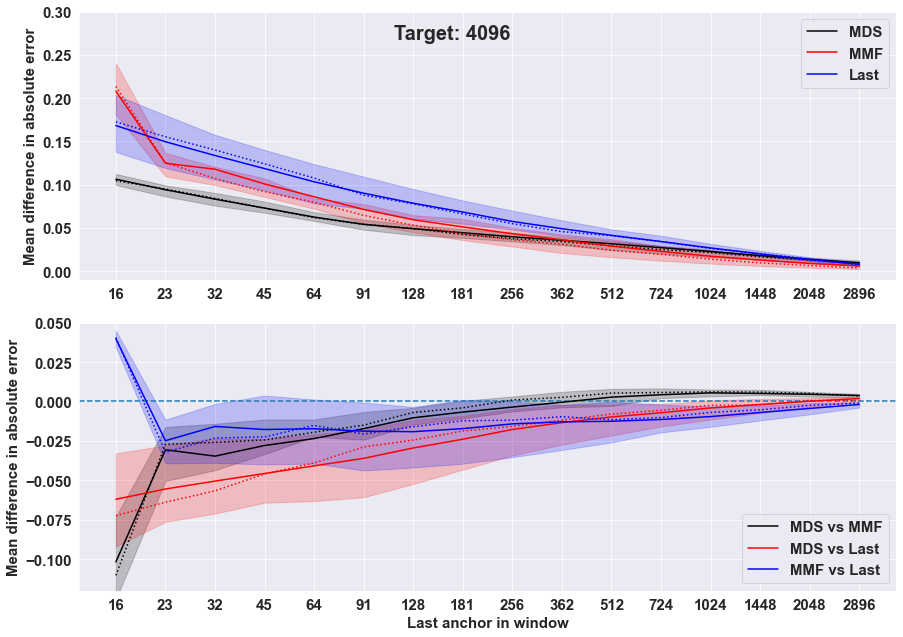

In [82]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots['MDS'] = {str(win.train_anchors[i]): KaveragesMDS[:,i,Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): KaveragesMMF[:,i,Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): KaveragesLast[:,i,Target] for i in ind}


plots2 = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots2['MDS vs MMF'] = {str(win.train_anchors[i]): KaveragesMDSvsMMF[:,i,Target] for i in ind}
plots2['MDS vs Last'] = {str(win.train_anchors[i]): KaveragesMDSvsLast[:,i,Target] for i in ind}
plots2['MMF vs Last'] = {str(win.train_anchors[i]): KaveragesMMFvsLast[:,i,Target] for i in ind}


ylim2 = (-0.12,0.05)
hline2 = 0
legend_loc2 = 'lower right'


title = 'Target: {}'.format(win.target_anchors[Target])
ylim = (-0.01,0.3)
figsize=(2, 2)
xlabel='Last anchor in window'
ylabel='Mean difference in absolute error'
Q1Q3=True
median=True
save='..\Plots\Paper\Regression1.png'
dpi=300
xrot=False
col=['black', 'red', 'blue', 'green']
legend_loc='upper right'
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(2,1,figsize=(6.4 * w, 4.8 * h))
if ylim:
    ax[0].set_ylim(*ylim)
    ax[1].set_ylim(*ylim2)
if ylabel:
    ax[0].set_ylabel(ylabel, fontsize=15, fontweight='bold')
    ax[1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
if xlabel:
    ax[1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

ax[1].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    means2 = [np.mean(dat) for dat in data2]

    ax[0].plot(means, c=c, label=plotlabels[i])
    ax[1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0].plot(medians, c=c, linestyle='dotted')
        ax[1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        ax[1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0].set_xticks(pos)
ax[1].set_xticks(pos)
plt.tight_layout()
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)
if n_dicts != 1:
    ax[0].legend(loc=legend_loc)
    ax[1].legend(loc=legend_loc2)
if save:
    plt.savefig(save, dpi=dpi)
plt.show()

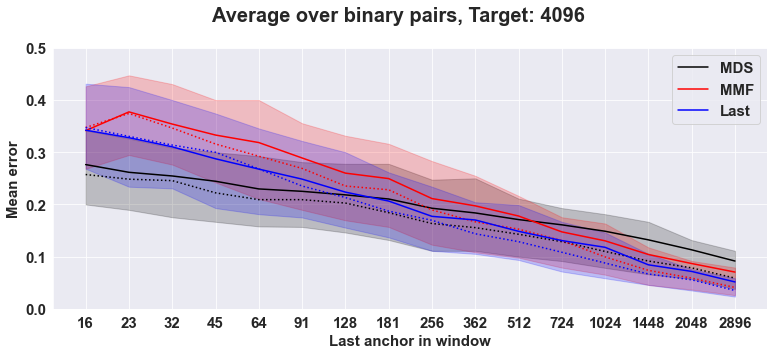

In [26]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error2[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error2[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error2[...,i, Target] for i in ind}

Meanplots(plots, title = 'Average over binary pairs, Target: {}'.format(win.target_anchors[Target]), ylim = (0,0.5), figsize=(2, 1), xlabel='Last anchor in window', ylabel='Mean error', Q1Q3=True, median=True)#, save='..\Plots\BinaryAggregation2\BinaryAggregation2Sensitivitytarget{}.png'.format(Target), dpi=300)

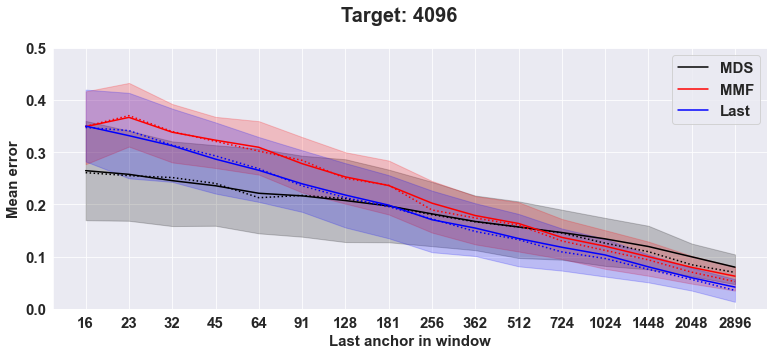

In [17]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}

Meanplots(plots, title = 'Target: {}'.format(win.target_anchors[Target]), ylim = (0,0.5), figsize=(2, 1), xlabel='Last anchor in window', ylabel='Mean error', Q1Q3=True, median=True, save='..\Plots\Paper\Binary1.png', dpi=300)

In [92]:
# Now for MDS vs MMF and MMF vs Last
# We take the mean at the end, so it says how many more times was MDS better than MMF
# So mean over DS is taken after the subtraction
Target = -4


plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}
plots['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}

path = '..\Plots\BinaryAggregation2Bplots\BinaryAggregation2Bplotstarget{}vs.png'.format(Target)
#Boxplots(plots, title = 'Target: {}'.format(win.target_anchors[Target]), ylim = (-0.3,0.3), figsize=(3, 1), hline = 0, save = path, xlabel='Last anchor in window', ylabel='Mean difference in error')

C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:5: RuntimeWarning: Mean of empty slice
  MDSvsMMF = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:6: RuntimeWarning: Mean of empty slice
  MMFvsLast = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:7: RuntimeWarning: Mean of empty slice
  MDSvsLast = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:9: RuntimeWarning: Mean of empty slice
  MDSvsMMF2 = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:10: RuntimeWarning: Mean of empty slice
  MMFvsLast2 = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=(1,2))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_8428\55964443.py:11: RuntimeWarning:

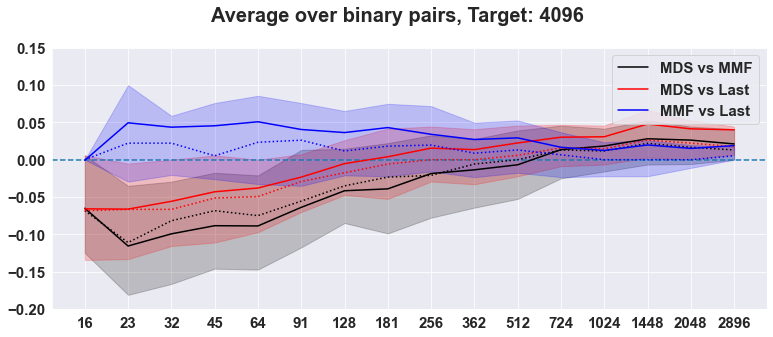

In [19]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF2[...,i, Target] for i in ind}
plots['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast2[...,i, Target] for i in ind}
plots['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast2[...,i, Target] for i in ind}


path = '..\Plots\BinaryAggregation2\BinaryAggregation2Sensitivitytarget{}vs.png'.format(Target)
Meanplots(plots, title = 'Average over binary pairs, Target: {}'.format(win.target_anchors[Target]), ylim = (-0.2,0.15), figsize=(2, 1), hline = 0)#, save = path, xlabel='Last anchor in window', ylabel='Mean difference in error')

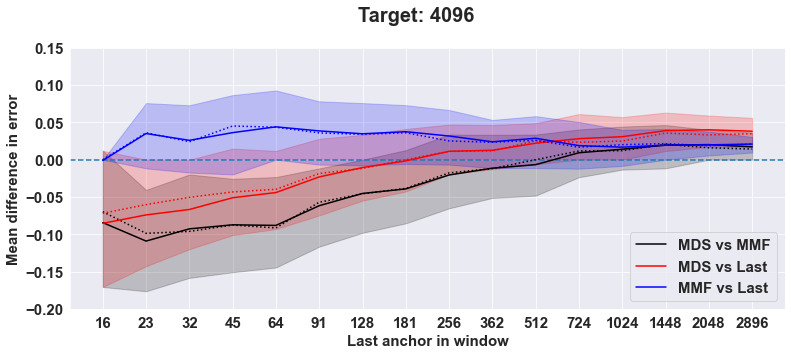

In [22]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
plots['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}


path = '..\Plots\Paper\Binary1vs.png'.format(Target)
Meanplots(plots, title = 'Target: {}'.format(win.target_anchors[Target]), ylim = (-0.2,0.15), figsize=(2, 1), hline = 0, save = path, legend_loc = 'lower right', xlabel='Last anchor in window', ylabel='Mean difference in error', dpi = 300)


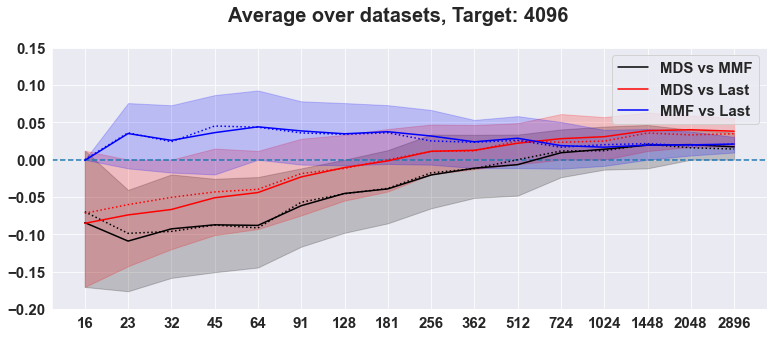

In [54]:
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
plots['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
plots['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}


path = '..\Plots\BinaryAggregation2\BinaryAggregation2target{}vs.png'.format(Target)
Meanplots(plots, title = 'Average over datasets, Target: {}'.format(win.target_anchors[Target]), ylim = (-0.2,0.15), figsize=(2, 1), hline = 0)#, save = path, xlabel='Last anchor in window', ylabel='Mean difference in error')


# 5. Heatmaps
Lets also do the heatmaps for completeness

In [17]:
# Averages for heatmap
# So now we have done mean over DS first, then mean over 1v1 learners
averagesMDSvsMMF = np.nanmean(MDSvsMMF, axis=(0,1))
averagesMMFvsLast = np.nanmean(MMFvsLast, axis=(0,1))
averagesMDSvsLast = np.nanmean(MDSvsLast, axis=(0,1))

ErrMDS = np.nanmean(MDS_error, axis=(0,1))
ErrMMF = np.nanmean(MMF_error, axis=(0,1))
ErrLast = np.nanmean(Last_error, axis=(0,1))

C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:3: RuntimeWarning: Mean of empty slice
  averagesMDSvsMMF = np.nanmean(MDSvsMMF, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:4: RuntimeWarning: Mean of empty slice
  averagesMMFvsLast = np.nanmean(MMFvsLast, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:5: RuntimeWarning: Mean of empty slice
  averagesMDSvsLast = np.nanmean(MDSvsLast, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:7: RuntimeWarning: Mean of empty slice
  ErrMDS = np.nanmean(MDS_error, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:8: RuntimeWarning: Mean of empty slice
  ErrMMF = np.nanmean(MMF_error, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\2751532277.py:9: RuntimeWarning: Mean of empty slice
  ErrLast = np.nanmean(Last_error, axis=(0,1))


C:\Users\lkiel\AppData\Local\Temp\ipykernel_8696\4252886537.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'seismic', vmin = -0.1, vmax = 0.1), cax=cbar_ax, label = 'Mean difference in error')


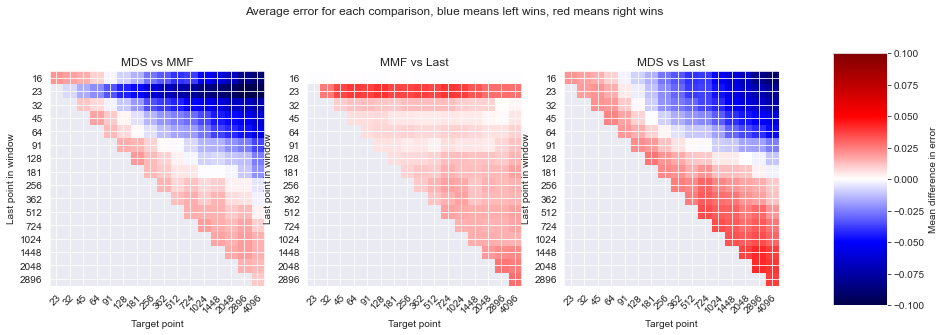

In [55]:
# plot the heatmaps for each side by side
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].imshow(averagesMDSvsMMF, cmap = 'seismic', vmin = -0.1, vmax = 0.1)
ax[2].imshow(averagesMMFvsLast, cmap = 'seismic', vmin = -0.1, vmax = 0.1)
ax[1].imshow(averagesMDSvsLast, cmap = 'seismic', vmin = -0.1, vmax = 0.1)

ax[0].set_title('MDS vs MMF')
ax[2].set_title('MMF vs Last')
ax[1].set_title('MDS vs Last')

# set (tick) labels
for i in range(3):
        ax[i].set_xticks(np.arange(len(win.target_anchors)))
        ax[i].set_yticks(np.arange(len(win.train_anchors)))
        ax[i].set_xticklabels(win.target_anchors)
        ax[i].set_yticklabels(win.train_anchors)
        ax[i].set_xlabel('Target point')
        ax[i].set_ylabel('Last point in window')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'seismic', vmin = -0.1, vmax = 0.1), cax=cbar_ax, label = 'Mean difference in error')

# set title
fig.suptitle('Average error for each comparison, blue means left wins, red means right wins')
path = '..\Plots\BinaryAggregation3\BinaryAggregation3heatmap.png'
plt.savefig(path, dpi=300)

In [44]:
ErrMDS

array([[0.14248035, 0.16676872, 0.19676422, 0.21556445, 0.22580366,
        0.23543188, 0.2458488 , 0.24714827, 0.25416551, 0.25682441,
        0.26933033, 0.26950282, 0.27645039, 0.27959818, 0.27285355,
        0.27084669],
       [       nan, 0.12023563, 0.15797531, 0.18356475, 0.19783765,
        0.21157308, 0.22204081, 0.22687262, 0.23302677, 0.23668238,
        0.247775  , 0.25190872, 0.26383699, 0.26704275, 0.26635636,
        0.26438754],
       [       nan,        nan, 0.12098642, 0.15025806, 0.16904498,
        0.18653354, 0.19924058, 0.20528643, 0.21412535, 0.22264797,
        0.2344625 , 0.23995113, 0.25041999, 0.25577805, 0.25497679,
        0.25156616],
       [       nan,        nan,        nan, 0.11172062, 0.13480143,
        0.15677085, 0.17233098, 0.18484098, 0.19524368, 0.20642566,
        0.22078638, 0.22748978, 0.23898994, 0.24644987, 0.24552473,
        0.2404592 ],
       [       nan,        nan,        nan,        nan, 0.10355019,
        0.1278294 , 0.14769618, 

In [39]:
print(np.nanmax(ErrMDS))
print(np.nanmax(ErrMMF))
print(np.nanmax(ErrLast))

print(np.nanmin(ErrMDS))
print(np.nanmin(ErrMMF))
print(np.nanmin(ErrLast))

0.2795981769588868
0.3702249509873527
0.3609046268648317
0.08013733019832901
0.0674579342161861
0.04106791341948247


We add regression to tighten figures

In [18]:
# since we don't have a nice heatmap function, we will do this by hand
kMMF = win.results['MMF']['test error']
kMDS = win.results['MDS']['test error']
kLast = win.results['Last']['test error']

KaveragesMMF = np.nanmean(kMMF, axis = 0)
KaveragesMDS = np.nanmean(kMDS, axis = 0)
KaveragesLast = np.nanmean(kLast, axis = 0)



KMDSvsMMF =  kMDS - kMMF
KaveragesMDSvsMMF = np.nanmean(KMDSvsMMF, axis = 0)
KMDSvsLast =  kMDS - kLast
KaveragesMDSvsLast = np.nanmean(KMDSvsLast, axis = 0)
KMMFvsLast =  kMMF - kLast
KaveragesMMFvsLast = np.nanmean(KMMFvsLast, axis = 0)

KmeanaveragesMDSvsMMF = np.nanmean(KaveragesMDSvsMMF, axis = 0)
KmeanaverageMDSvsLast = np.nanmean(KaveragesMDSvsLast, axis = 0)
KmeanaveragesMMFvsLast = np.nanmean(KaveragesMMFvsLast, axis = 0)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:6: RuntimeWarning: Mean of empty slice
  KaveragesMMF = np.nanmean(kMMF, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:7: RuntimeWarning: Mean of empty slice
  KaveragesMDS = np.nanmean(kMDS, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:8: RuntimeWarning: Mean of empty slice
  KaveragesLast = np.nanmean(kLast, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:13: RuntimeWarning: Mean of empty slice
  KaveragesMDSvsMMF = np.nanmean(KMDSvsMMF, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:15: RuntimeWarning: Mean of empty slice
  KaveragesMDSvsLast = np.nanmean(KMDSvsLast, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:17: RuntimeWarning: Mean of empty slice
  KaveragesMMFvsLast = np.nanmean(KMMFvsLast, axis = 0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\919320513.py:19: RuntimeWarning: Me

In [22]:
from matplotlib import ticker
#For regret
regretAveragesMDSvsMMF = np.nanmean(MDSregretvsMMFregret, axis=(0,1))
regretAveragesMDSvsLast = np.nanmean(MDSregretvsLastregret, axis=(0,1))
regretAveragesMMFvsLast = np.nanmean(MMFregretvsLastregret, axis=(0,1))


C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\493738547.py:3: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsMMF = np.nanmean(MDSregretvsMMFregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\493738547.py:4: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsLast = np.nanmean(MDSregretvsLastregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\493738547.py:5: RuntimeWarning: Mean of empty slice
  regretAveragesMMFvsLast = np.nanmean(MMFregretvsLastregret, axis=(0,1))


C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\3903650240.py:105: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_3748\3903650240.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


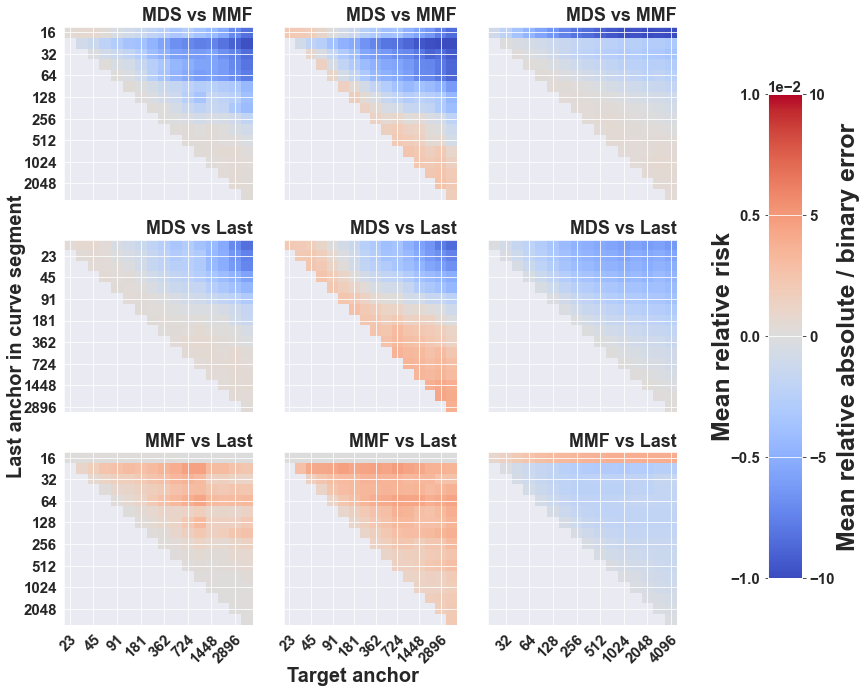

In [32]:
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# w = 2
# h = 3.5
w, h = (1.5, 2)
fig, ax = plt.subplots(3,3, figsize=(6.4 * w, 4.8 * h))


a = ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[1][0].imshow(regretAveragesMDSvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[2][0].imshow(regretAveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')


b = ax[0][1].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[2][1].imshow(averagesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[1][1].imshow(averagesMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)

# set title
ax[0][0].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][0].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][0].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][1].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][1].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][1].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][2].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][2].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][2].set_title('MDS vs Last', weight = 'bold', loc='right')

c = ax[0][2].imshow(KmeanaveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[1][2].imshow(KmeanaverageMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[2][2].imshow(KmeanaveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')

# set (tick) labela
sl = slice(0, len(win.target_anchors), 2)
sl2 = slice(1, len(win.target_anchors), 2)

for i in range(3):
    ax[i][0].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][0].set_xticklabels(win.target_anchors[sl])
    ax[i][0].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax[i][1].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][1].set_xticklabels(win.target_anchors[sl])
    ax[i][1].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    ax[i][2].set_xticks(np.arange(len(win.target_anchors))[sl2])
    ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][2].set_xticklabels(win.target_anchors[sl2])
    ax[i][2].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # if i is 1 or 2
    if i == 1 or i == 0:
        ax[i][0].xaxis.set_ticklabels([])
        ax[i][1].xaxis.set_ticklabels([])
        ax[i][2].xaxis.set_ticklabels([])


    if i == 1:
        ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][2].set_yticklabels(win.train_anchors[sl2])
        ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][0].set_yticklabels(win.train_anchors[sl2])
        ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][1].set_yticklabels(win.train_anchors[sl2])

    ax[i][1].yaxis.set_ticklabels([])
    ax[i][2].yaxis.set_ticklabels([])

# set colorbar for all subplots the same
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
#cb = fig.colorbar(ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
#cb.set_label(label = 'Mean difference in binary / absolute error', weight = 'bold', labelpad=-90, size = 25)

# dividers
plots = [a,b,c]
# for i in range(3):
#     divider = make_axes_locatable(ax[1][i])
#     cax = divider.append_axes('right', size='5%')
#     cb = fig.colorbar(plots[i], cax=cax, orientation='vertical')
#     tick_locator = ticker.MaxNLocator(nbins=4)
#     cb.locator = tick_locator
#     cb.formatter.set_powerlimits((0, 0))
#     cb.update_ticks()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
cb.set_label(label = 'Mean relative risk', weight = 'bold', labelpad=-90, size = 25)

pos = cb.ax.get_position()
cb.ax.set_aspect('auto')
ax2 = cb.ax.twinx()
ax2.set_ylim([-0.01*1000, 0.01*1000])
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
#ax2.yaxis.set_major_formatter(plt.set_powerlimits((0, 0)))

tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

cb.formatter.set_powerlimits((0, 0))

fig.text(0.5, 0, "Target anchor", ha='center', fontsize=20, fontweight='bold')
fig.text(0, 0.5, "Last anchor in curve segment", va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(1.2, 0.5, "Mean relative absolute / binary error", va='center', rotation=90, fontsize=25, fontweight='bold')
fig.tight_layout()
path = '..\Plots\Paper\Agg3zoomout.pdf'
plt.savefig(path, dpi=300, bbox_inches='tight')

In [219]:
4 * 10**(-3)

0.004

In [223]:
print(np.nanmin(averagesMDSvsMMF))
print(np.nanmin(averagesMDSvsLast))
print(np.nanmin(averagesMMFvsLast))

-0.10915543387395196
-0.08534772467996121
-0.0009705233629728123


C:\Users\lkiel\AppData\Local\Temp\ipykernel_3500\1542471891.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.001, vmax=0.001, aspect='auto'), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_3500\1542471891.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


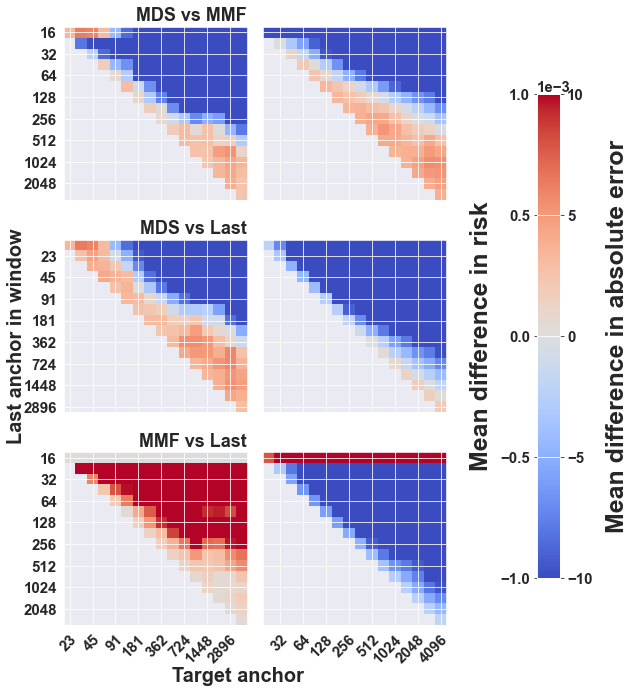

In [56]:
# w = 2
# h = 3.5
w, h = (1, 2)
fig, ax = plt.subplots(3,2, figsize=(6.4 * w, 4.8 * h))

ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.001, vmax = 0.001, aspect='auto')
ax[1][0].imshow(regretAveragesMDSvsLast, cmap = 'coolwarm', vmin = -0.001, vmax = 0.001, aspect='auto')
ax[2][0].imshow(regretAveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.001, vmax = 0.001, aspect='auto')

# set title
ax[0][0].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][0].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][0].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][1].imshow(KmeanaveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[1][1].imshow(KmeanaverageMDSvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[2][1].imshow(KmeanaveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')

# set (tick) labela
sl = slice(0, len(win.target_anchors), 2)
sl2 = slice(1, len(win.target_anchors), 2)

for i in range(3):
    ax[i][0].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][0].set_xticklabels(win.target_anchors[sl])
    ax[i][0].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    ax[i][1].set_xticks(np.arange(len(win.target_anchors))[sl2])
    ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][1].set_xticklabels(win.target_anchors[sl2])
    ax[i][1].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # if i is 1 or 2
    if i == 1 or i == 0:
        ax[i][0].xaxis.set_ticklabels([])
        ax[i][1].xaxis.set_ticklabels([])


    if i == 1:
        ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][1].set_yticklabels(win.train_anchors[sl2])
        ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][0].set_yticklabels(win.train_anchors[sl2])

    ax[i][1].yaxis.set_ticklabels([])

# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.15, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.001, vmax=0.001, aspect='auto'), cax=cbar_ax)
cb.set_label(label = 'Mean difference in risk', weight = 'bold', labelpad=-90, size = 25)

pos = cb.ax.get_position()
cb.ax.set_aspect('auto')
ax2 = cb.ax.twinx()
ax2.set_ylim([-0.01*1000, 0.01*1000])
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
#ax2.yaxis.set_major_formatter(plt.set_powerlimits((0, 0)))

tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

cb.formatter.set_powerlimits((0, 0))


fig.text(0.5, 0, "Target anchor", ha='center', fontsize=20, fontweight='bold')
fig.text(0, 0.5, "Last anchor in window", va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(1.3, 0.5, "Mean difference in absolute error", va='center', rotation=90, fontsize=25, fontweight='bold')
fig.tight_layout()
path = '..\Plots\Paper\Agg3RegretAbs.png'
plt.savefig(path, dpi=300, bbox_inches='tight')

C:\Users\lkiel\AppData\Local\Temp\ipykernel_16804\3350609614.py:53: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax=0.1), cax=cbar_ax)


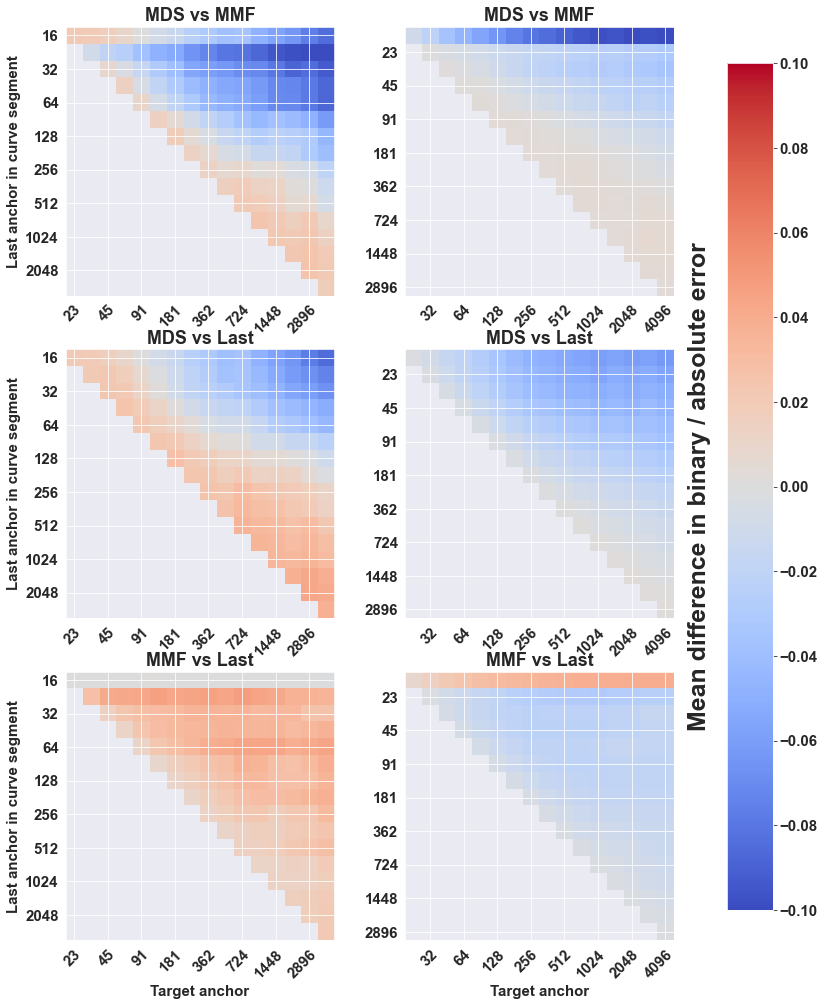

In [26]:
w = 2
h = 3.5
fig, ax = plt.subplots(3,2, figsize=(6.4 * w, 4.8 * h))

ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[2][0].imshow(averagesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[1][0].imshow(averagesMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)

# set title
ax[0][0].set_title('MDS vs MMF', weight = 'bold')
ax[2][0].set_title('MMF vs Last', weight = 'bold')
ax[1][0].set_title('MDS vs Last', weight = 'bold')

ax[0][1].imshow(KmeanaveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[1][1].imshow(KmeanaverageMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[2][1].imshow(KmeanaveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)

# set title
ax[0][1].set_title('MDS vs MMF', weight = 'bold')
ax[2][1].set_title('MMF vs Last', weight = 'bold')
ax[1][1].set_title('MDS vs Last', weight = 'bold')

# set (tick) labela
sl = slice(0, len(win.target_anchors), 2)
sl2 = slice(1, len(win.target_anchors), 2)
for i in range(3):
        ax[i][0].set_xticks(np.arange(len(win.target_anchors))[sl])
        ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl])
        ax[i][0].set_xticklabels(win.target_anchors[sl])
        ax[i][0].set_yticklabels(win.train_anchors[sl])
        ax[i][0].set_ylabel('Last anchor in curve segment', weight = 'bold')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i][0].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        ax[i][1].set_xticks(np.arange(len(win.target_anchors))[sl2])
        ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][1].set_xticklabels(win.target_anchors[sl2])
        ax[i][1].set_yticklabels(win.train_anchors[sl2])

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i][1].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")



ax[2][0].set_xlabel('Target anchor', weight = 'bold')
ax[2][1].set_xlabel('Target anchor', weight = 'bold')
# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax=0.1), cax=cbar_ax)
cb.set_label(label = 'Mean difference in binary / absolute error', weight = 'bold', labelpad=-130, size = 25)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()

path = '..\Plots\Paper\Agg3BinaryAbs.png'
plt.savefig(path, dpi=300)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_19140\977023140.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19140\977023140.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


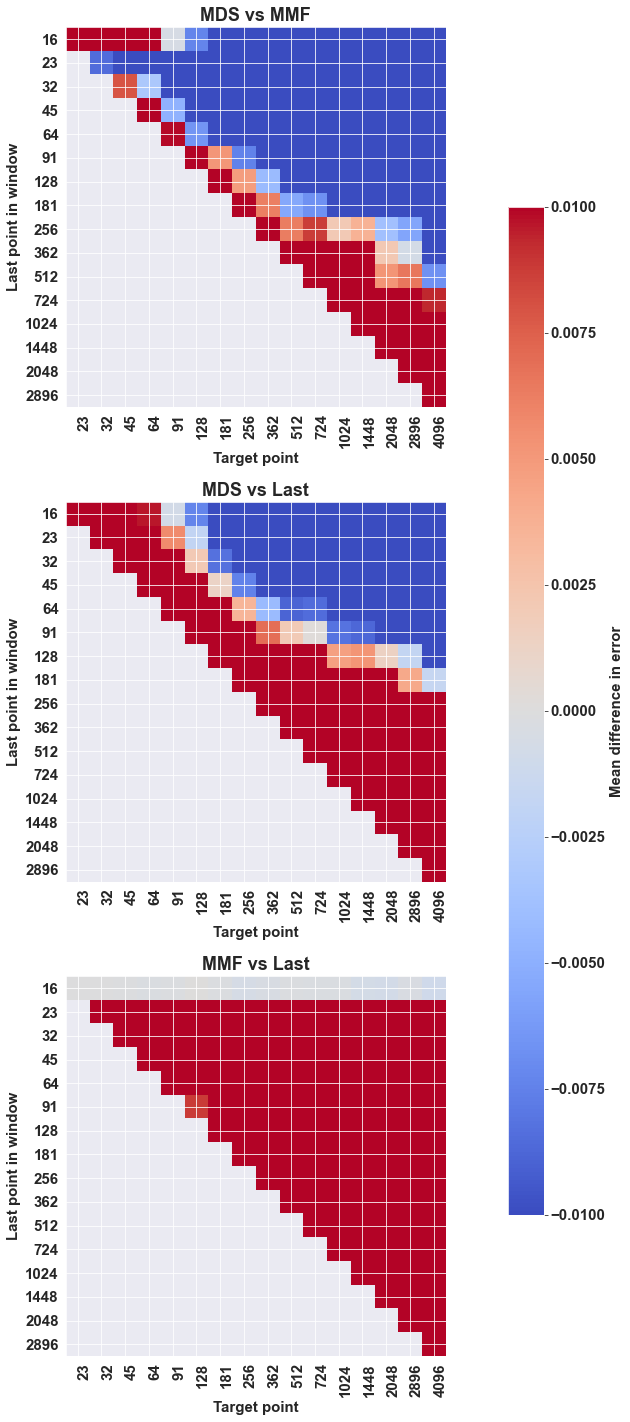

In [121]:
fig, ax = plt.subplots(3,1, figsize = (10,20))

ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01)
ax[2].imshow(averagesMMFvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01)
ax[1].imshow(averagesMDSvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01)

# set title
ax[0].set_title('MDS vs MMF', weight = 'bold')
ax[2].set_title('MMF vs Last', weight = 'bold')
ax[1].set_title('MDS vs Last', weight = 'bold')

# set (tick) labela
for i in range(3):
        ax[i].set_xticks(np.arange(len(win.target_anchors)))
        ax[i].set_yticks(np.arange(len(win.train_anchors)))
        ax[i].set_xticklabels(win.target_anchors)
        ax[i].set_yticklabels(win.train_anchors)
        ax[i].set_xlabel('Target point', weight = 'bold')
        ax[i].set_ylabel('Last point in window', weight = 'bold')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")

# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01), cax=cbar_ax)
cb.set_label(label = 'Mean difference in error', weight = 'bold')

plt.tight_layout()
path = '..\Plots\BinaryAggregation3\BinaryAggregation3heatmapVsZoom.png'
#plt.savefig(path, dpi=300)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_7412\3758025620.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0].imshow(ErrMDS, cmap = 'coolwarm', vmin=0, vmax=0.1), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7412\3758025620.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


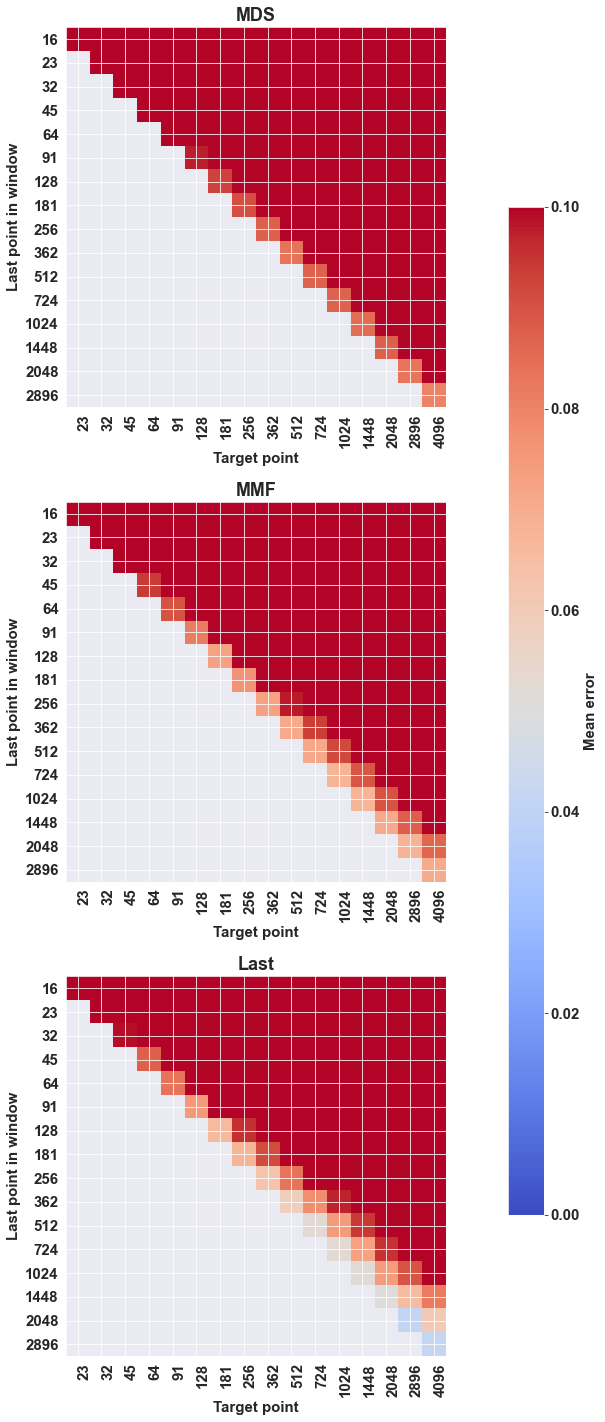

In [46]:
fig, ax = plt.subplots(3,1, figsize = (10,20))

ax[0].imshow(ErrMDS, cmap = 'coolwarm', vmin=0, vmax = 0.1)
ax[1].imshow(ErrMMF, cmap = 'coolwarm', vmin=0, vmax = 0.1)
ax[2].imshow(ErrLast, cmap = 'coolwarm', vmin=0, vmax = 0.1)

# set title
ax[0].set_title('MDS', weight = 'bold')
ax[1].set_title('MMF', weight = 'bold')
ax[2].set_title('Last', weight = 'bold')

# set (tick) labela
for i in range(3):
        ax[i].set_xticks(np.arange(len(win.target_anchors)))
        ax[i].set_yticks(np.arange(len(win.train_anchors)))
        ax[i].set_xticklabels(win.target_anchors)
        ax[i].set_yticklabels(win.train_anchors)
        ax[i].set_xlabel('Target point', weight = 'bold')
        ax[i].set_ylabel('Last point in window', weight = 'bold')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")

# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0].imshow(ErrMDS, cmap = 'coolwarm', vmin=0, vmax=0.1), cax=cbar_ax)
cb.set_label(label = 'Mean error', weight = 'bold')

plt.tight_layout()
path = '..\Plots\BinaryAggregation3\BinaryAggregation3heatmapZoom.png'
plt.savefig(path, dpi=300)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_14396\3264155594.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm'), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_14396\3264155594.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


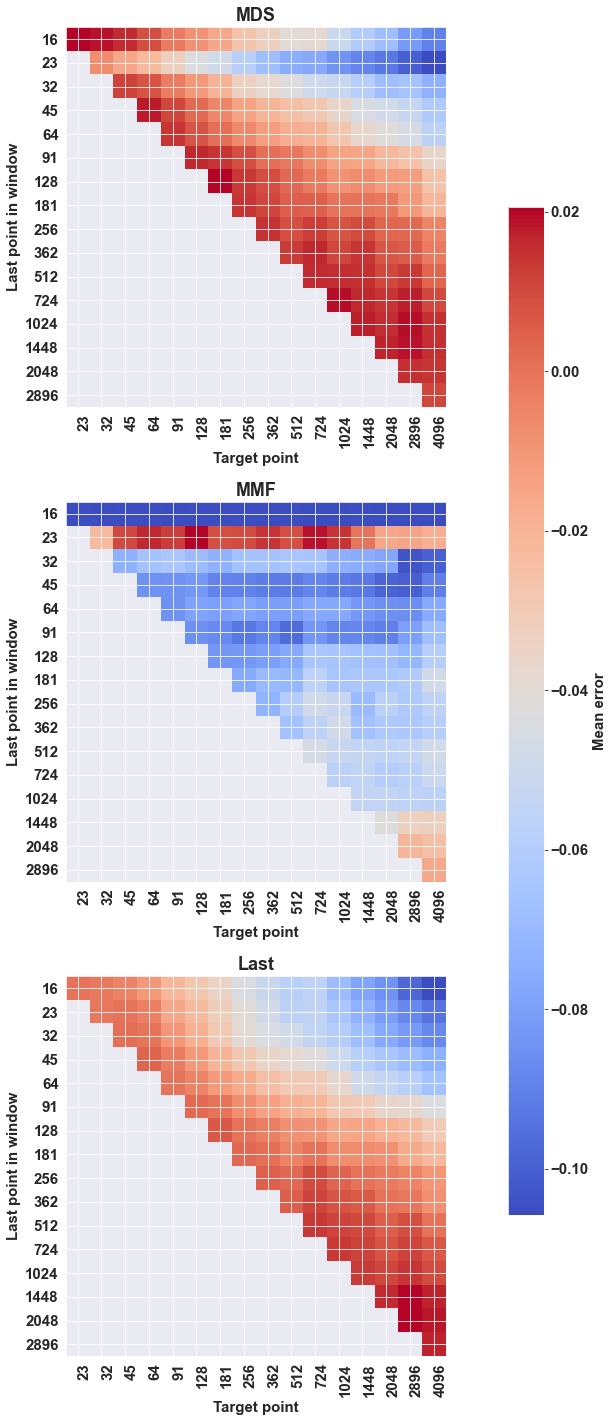

In [119]:
fig, ax = plt.subplots(3,1, figsize = (10,20))

ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm')
ax[1].imshow(averagesMMFvsLast, cmap = 'coolwarm')
ax[2].imshow(averagesMDSvsLast, cmap = 'coolwarm')

# set title
ax[0].set_title('MDS', weight = 'bold')
ax[1].set_title('MMF', weight = 'bold')
ax[2].set_title('Last', weight = 'bold')

# set (tick) labela
for i in range(3):
        ax[i].set_xticks(np.arange(len(win.target_anchors)))
        ax[i].set_yticks(np.arange(len(win.train_anchors)))
        ax[i].set_xticklabels(win.target_anchors)
        ax[i].set_yticklabels(win.train_anchors)
        ax[i].set_xlabel('Target point', weight = 'bold')
        ax[i].set_ylabel('Last point in window', weight = 'bold')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")

# set colorbar for all subplots the same
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0].imshow(averagesMDSvsMMF, cmap = 'coolwarm'), cax=cbar_ax)
cb.set_label(label = 'Mean error', weight = 'bold')

plt.tight_layout()
path = '..\Plots\BinaryAggregation3\BinaryAggregation3heatmapVsZoom.png'
plt.savefig(path, dpi=300)

In [112]:
print(np.sum(averagesMDSvsMMF > 0.1))
print(np.sum(averagesMDSvsMMF < -0.1))
# same for mmf vs last
print(np.sum(averagesMMFvsLast > 0.1))
print(np.sum(averagesMMFvsLast < -0.1))
# same for mds vs last
print(np.sum(averagesMDSvsLast > 0.1))
print(np.sum(averagesMDSvsLast < -0.1))


0
2
0
0
0
0


In [14]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

print(MDSbinary.flatten()[~np.isnan(MDSbinary.flatten())].shape)
print(MMF.flatten()[~np.isnan(MMF.flatten())].shape)
print(Last.flatten()[~np.isnan(Last.flatten())].shape)
print(actual.flatten()[~np.isnan(actual.flatten())].shape)


(6690802,)
(6690802,)
(6690802,)
(6690802,)


In [101]:
win.target_anchors

array([  23,   32,   45,   64,   91,  128,  181,  256,  362,  512,  724,
       1024, 1448, 2048, 2896, 4096])

In [115]:


dispMDS.plot(ax=ax[0], cmap='coolwarm', colorbar=False)
dispMMF.plot(ax=ax[1], cmap='coolwarm', colorbar=False)

for i in range(2):
    ax[i].set_xlabel('Predicted Value', weight = 'bold')
    ax[i].set_ylabel('True Value', weight = 'bold')

# set title
ax[0].set_title('MDS', weight='bold')
ax[1].set_title('MMF', weight='bold')

title = ('Last anchor in window: {}, Target: {}'.format(win.train_anchors[window],win.target_anchors[tar]))
fig.suptitle(title, y=1, fontsize=20, fontweight='bold')

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

In [122]:
MDSbinary[...,window,tar]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [120]:
window = -1
tar = 0
MDSbinary[...,window,tar].flatten()[~np.isnan(MDSbinary[...,window,tar].flatten())]

array([], dtype=float64)

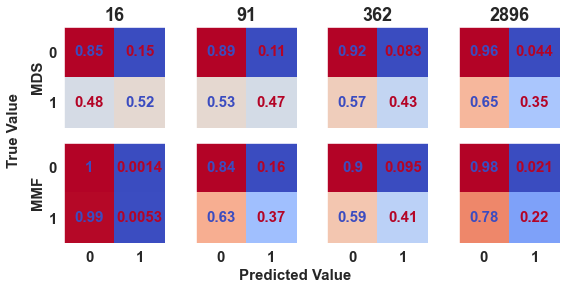

In [15]:
i = 2
fig, ax = plt.subplots(2, 4, figsize=(4*i, 2*i))
for a in ax:
    for aa in a:
        aa.grid(False)

tar = -1
windows = [0,5,9,-1]

for i in range(len(windows)):
    window = windows[i]
    # Round 0.5 down to 0 with int, as then a does not beat b


    MDSpred = MDSbinary[...,window,tar].flatten()[~np.isnan(MDSbinary[...,window,tar].flatten())]
    MMFpred = MMF[...,window,tar].flatten()[~np.isnan(MMF[...,window,tar].flatten())]
    Lastpred = Last[...,window,tar].flatten()[~np.isnan(Last[...,window,tar].flatten())]
    actualpred = actual[...,window,tar].flatten()[~np.isnan(actual[...,window,tar].flatten())]

    # Now to check when it predicts learning curve crossing
    # The LastError gives 1 if LC cross and 0 if not
    LastError = np.abs(actualpred - Lastpred)
    MDSerror = np.abs(actualpred - MDSpred)
    MMFerror = np.abs(actualpred - MMFpred)

    # When Lasterror is a tie there is no crossing
    LastError[LastError == 0.5] = 0

    # When error is 0 it correctly guesses
    MDSpred[MDSerror == 0] = LastError[MDSerror == 0]
    MMFpred[MMFerror == 0] = LastError[MMFerror == 0]

    # When error is 1 it incorrectly guesses
    MDSpred[MDSerror == 1] = 1 - LastError[MDSerror == 1]
    MMFpred[MMFerror == 1] = 1 - LastError[MMFerror == 1]

    # When it is a tie it predicts no crossing
    MDSpred[MDSerror == 0.5] = 0
    MMFpred[MMFerror == 0.5] = 0

    # MDS
    cmMDS = confusion_matrix(LastError, MDSpred, normalize='true')
    dispMDS = ConfusionMatrixDisplay(confusion_matrix=cmMDS)
    dispMDS.plot(ax=ax[0,i], cmap='coolwarm', colorbar=False)
    ax[0,i].set_xlabel('')
    ax[0,i].set_ylabel('')
    ax[0,0].set_ylabel('MDS', weight = 'bold')
    ax[0,i].set_title('{}'.format(win.train_anchors[window]), weight='bold')
    ax[0,i].set_xticklabels(['',''])

    # MMF
    cmMMF = confusion_matrix(LastError, MMFpred, normalize='true')
    dispMMF = ConfusionMatrixDisplay(confusion_matrix=cmMMF)
    dispMMF.plot(ax=ax[1,i], cmap='coolwarm', colorbar=False)
    ax[1,i].set_xlabel('')
    ax[1,i].set_ylabel('')
    ax[1,0].set_ylabel('MMF', weight = 'bold')

    if i == 0:
        continue
    ax[0,i].set_yticklabels(['',''])
    ax[1,i].set_yticklabels(['',''])

fig.text(0.0, 0.52, 'True Value', va='center', rotation='vertical', weight = 'bold')
fig.text(0.5, 0.0, 'Predicted Value', ha='center', weight = 'bold')

plt.tight_layout()
path = '..\Plots\Paper\All.pdf'
plt.savefig(path, dpi=300)

In [9]:
# Plot of prob of crossing over size of window
tar = -1

LastError = np.abs(Last - actual)[...,tar]

# 0.5 means Last or Actual have a tie, in either case there is no learning curve crossing
# thus we take this as an error of 0 essentially
# actually the learning curve might cross on the last anchor in the window, but we ignore this
# we only check if crossing happens after the window
probabilities = np.count_nonzero(LastError == 1, axis = (0,1,2)) / np.count_nonzero(LastError <= 1, axis = (0,1,2))

In [96]:
probabilities

array([0.34167252, 0.32290935, 0.30337316, 0.27962052, 0.25832748,
       0.23429375, 0.2132818 , 0.19508082, 0.16753338, 0.15249473,
       0.13253689, 0.11560084, 0.10098384, 0.07856641, 0.05952214,
       0.04202389])

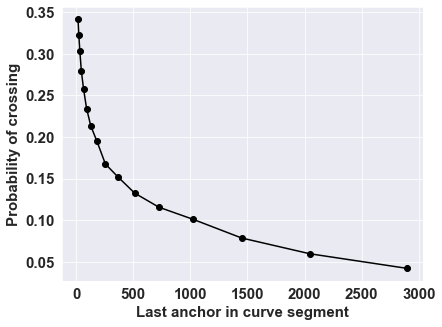

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6.4*1, 4.8*1))

plt.plot(win.train_anchors, probabilities, marker = 'o', color = 'black')
plt.xlabel('Last anchor in curve segment', weight = 'bold')
plt.ylabel('Probability of crossing', weight = 'bold')

# title = ('Probability of Learning curves crossing for Target: {}'.format(win.target_anchors[tar]))
# fig.suptitle(title, y=1, fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig('../Plots/Paper_old/ProbabilityOfCrossing.pdf', dpi=300)

In [96]:
actualpred[1,0,2,7]

0.0

In [97]:
MMFerror[1,0,2,7]

0.0

In [98]:
Lastpred[1,0,2,6]

1.0

In [99]:
MMFpred[1,0,2,7]

1.0

In [57]:
tar = -1
MDSpred = MDSbinary[...,tar]
MMFpred = MMF[...,tar]
Lastpred = Last[...,tar]
actualpred = actual[...,tar]


# Now to check when it predicts learning curve crossing
# The LastError gives 1 if LC cross and 0 if not
LastError = np.abs(actualpred - Lastpred)
MDSerror = np.abs(actualpred - MDSpred)
MMFerror = np.abs(actualpred - MMFpred)

# When Lasterror is a tie there is no crossing
LastError[LastError == 0.5] = 0

# When error is 0 it correctly guesses
MDSpred[MDSerror == 0] = LastError[MDSerror == 0]
MMFpred[MMFerror == 0] = LastError[MMFerror == 0]

# When error is 1 it incorrectly guesses
MDSpred[MDSerror == 1] = 1 - LastError[MDSerror == 1]
MMFpred[MMFerror == 1] = 1 - LastError[MMFerror == 1]

# When it is a tie it predicts no crossing
MDSpred[MDSerror == 0.5] = 0
MMFpred[MMFerror == 0.5] = 0

print(MMFpred.shape)

(248, 20, 20, 16)


In [108]:
print(LastError[1,0,2,6])
print(MMFpred[1,0,2,6])

1.0
0.0


In [39]:
np.where(LastError[np.where(temp1 != temp2)] == 0)[0][-2000:]

array([222476, 222477, 222491, ..., 224894, 224895, 224896], dtype=int64)

In [40]:
i = 222476
print(LastError[ a[i],b[i],c[i],d[i]])
print(MMFpred[ a[i],b[i],c[i],d[i]])
print(a[i],b[i],c[i],d[i])

0.0
1.0
243 10 11 14


In [58]:
temp1 = MMFpred.copy()
temp2 = LastError.copy()
temp1[np.isnan(temp1)] = 0
temp2[np.isnan(temp2)] = 0

# look for false positive and false negative
a,b,c,d = np.where(temp1 != temp2)
i = slice(-10,-1)
print(a[i],b[i],c[i],d[i])

[245 245 245 245 245 245 245 245 245] [19 19 19 19 19 19 19 19 19] [16 16 17 17 17 18 18 18 18] [2 3 0 1 2 0 1 2 3]


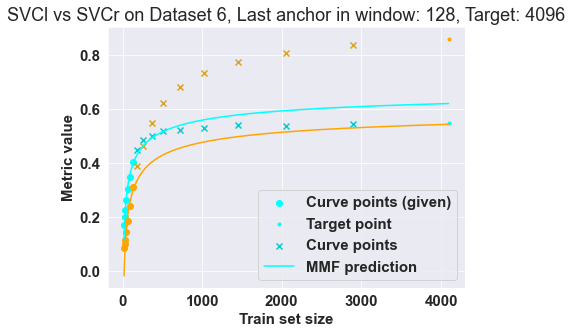

In [113]:
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])

# False negative
datasetFN, learner1FN, learner2FN, windowFN, target = 1,0,2,6,-1

# Curve points, we also take the regularised points and put them back in to see
# Leaner 1
ax.scatter(win.train_anchors[:windowFN + 1], win.segment[datasetFN, learner1FN][:windowFN + 1], color='cyan',
                   marker='o', label='Curve points (given)')
ax.scatter(win.target_anchors[target], win.label[datasetFN, learner1FN, target], color='cyan', label='Target point', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFN])[0][0]
ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetFN, learner1FN, startID+1:stopID], color='darkturquoise', marker='x',
                   label='Curve points')

# Learner 2
ax.scatter(win.train_anchors[:windowFN + 1], win.segment[datasetFN, learner2FN][:windowFN + 1], color='orange',
                   marker='o')
ax.scatter(win.target_anchors[target], win.label[datasetFN, learner2FN, target], color='orange', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFN])[0][0]
ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetFN, learner2FN, startID+1:stopID], color='goldenrod', marker='x')

# MMF prediction plot
# Learner 1
x = np.linspace(win.train_anchors[0], win.target_anchors[target], 10000)
a, b, c, d = win.results['MMF']['parameters'][datasetFN, learner1FN, 0, windowFN]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), label='MMF prediction', color='cyan')

# Learner 2
a, b, c, d = win.results['MMF']['parameters'][datasetFN, learner2FN, 0, windowFN]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), color='orange')

# set y axis and x axis name
ax.set_ylabel('Metric value', weight='bold')
ax.set_xlabel('Train set size', weight='bold')

ax.set_title('{} vs {} on Dataset {}, Last anchor in window: {}, Target: {}'.format(win.Slearners[learner1FN],win.Slearners[learner2FN],win.datasets[datasetFN], win.train_anchors[windowFN],win.target_anchors[target]))


ax.legend()

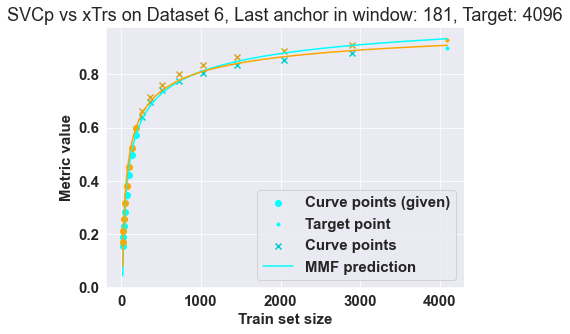

In [154]:
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])

# False positive
datasetFP, learner1FP, learner2FP, windowFP = 1, 1, 4, 7

# Curve points, we also take the regularised points and put them back in to see
# Leaner 1
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner1FP][:windowFP + 1], color='cyan',
                   marker='o', label='Curve points (given)')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner1FP, target], color='cyan', label='Target point', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetFP, learner1FP, startID+1:stopID], color='darkturquoise', marker='x',
                   label='Curve points')

# Learner 2
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner2FP][:windowFP + 1], color='orange',
                   marker='o')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner2FP, target], color='orange', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetFP, learner2FP, startID+1:stopID], color='goldenrod', marker='x')

# MMF prediction plot
# Learner 1
x = np.linspace(win.train_anchors[0], win.target_anchors[target], 10000)
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner1FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), label='MMF prediction', color='cyan')

# Learner 2
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner2FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), color='orange')

# set y axis and x axis name
ax.set_ylabel('Metric value', weight='bold')
ax.set_xlabel('Train set size', weight='bold')

ax.set_title('{} vs {} on Dataset {}, Last anchor in window: {}, Target: {}'.format(win.Slearners[learner1FP],win.Slearners[learner2FP],win.datasets[datasetFP], win.train_anchors[windowFP],win.target_anchors[target]))

ax.legend()

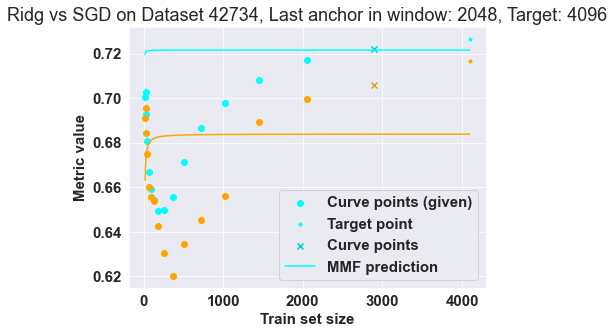

In [41]:
target = -1
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])

# False positive
datasetFP, learner1FP, learner2FP, windowFP = 243, 10, 11, 14

# Curve points, we also take the regularised points and put them back in to see
# Leaner 1
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner1FP][:windowFP + 1], color='cyan',
           marker='o', label='Curve points (given)')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner1FP, target], color='cyan', label='Target point',
           marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID + 1:stopID], win.dataframe[datasetFP, learner1FP, startID + 1:stopID],
           color='darkturquoise', marker='x',
           label='Curve points')

# Learner 2
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner2FP][:windowFP + 1], color='orange',
           marker='o')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner2FP, target], color='orange', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID + 1:stopID], win.dataframe[datasetFP, learner2FP, startID + 1:stopID], color='goldenrod',
           marker='x')

# MMF prediction plot
# Learner 1
x = np.linspace(win.train_anchors[0], win.target_anchors[target], 10000)
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner1FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), label='MMF prediction', color='cyan')

# Learner 2
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner2FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), color='orange')

# set y axis and x axis name
ax.set_ylabel('Metric value', weight='bold')
ax.set_xlabel('Train set size', weight='bold')

ax.set_title('{} vs {} on Dataset {}, Last anchor in window: {}, Target: {}'.format(win.Slearners[learner1FP],
                                                                                    win.Slearners[learner2FP],
                                                                                    win.datasets[datasetFP],
                                                                                    win.train_anchors[windowFP],
                                                                                    win.target_anchors[target]))

ax.legend()

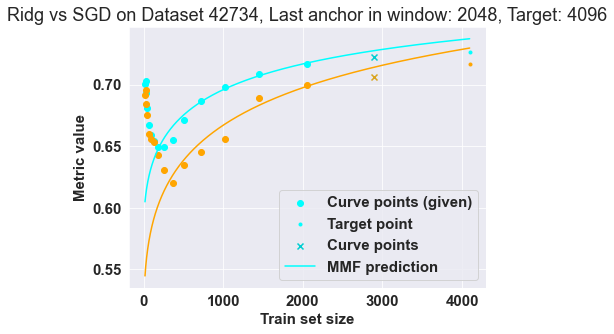

In [64]:
target = -1
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])

# False positive
datasetFP, learner1FP, learner2FP, windowFP = 243, 10, 11, 14

# Curve points, we also take the regularised points and put them back in to see
# Leaner 1
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner1FP][:windowFP + 1], color='cyan',
           marker='o', label='Curve points (given)')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner1FP, target], color='cyan', label='Target point',
           marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID + 1:stopID], win.dataframe[datasetFP, learner1FP, startID + 1:stopID],
           color='darkturquoise', marker='x',
           label='Curve points')

# Learner 2
ax.scatter(win.train_anchors[:windowFP + 1], win.segment[datasetFP, learner2FP][:windowFP + 1], color='orange',
           marker='o')
ax.scatter(win.target_anchors[target], win.label[datasetFP, learner2FP, target], color='orange', marker='.')

stopID = np.where(win.points == win.target_anchors[target])[0][0]
startID = np.where(win.points == win.train_anchors[windowFP])[0][0]
ax.scatter(win.points[startID + 1:stopID], win.dataframe[datasetFP, learner2FP, startID + 1:stopID], color='goldenrod',
           marker='x')

# MMF prediction plot
# Learner 1
x = np.linspace(win.train_anchors[0], win.target_anchors[target], 10000)
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner1FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), label='MMF prediction', color='cyan')

# Learner 2
a, b, c, d = win.results['MMF']['parameters'][datasetFP, learner2FP, 0, windowFP]
fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
ax.plot(x, fun(x), color='orange')

# set y axis and x axis name
ax.set_ylabel('Metric value', weight='bold')
ax.set_xlabel('Train set size', weight='bold')

ax.set_title('{} vs {} on Dataset {}, Last anchor in window: {}, Target: {}'.format(win.Slearners[learner1FP],
                                                                                    win.Slearners[learner2FP],
                                                                                    win.datasets[datasetFP],
                                                                                    win.train_anchors[windowFP],
                                                                                    win.target_anchors[target]))

ax.legend()